In [304]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, roc_auc_score, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_columns', 100)
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 10

In [305]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [306]:
#Encoding the target variabe
train["default_status"] = LabelEncoder().fit_transform(train["default_status"])

In [307]:
train["form_field47"] = LabelEncoder().fit_transform(train["form_field47"])
test["form_field47"] = LabelEncoder().fit_transform(test["form_field47"])

In [308]:
# Select only numeric features
features = train.columns.drop(['Applicant_ID', 'default_status'])

In [309]:
test_id = test.Applicant_ID
X = pd.get_dummies(train[features])
y = train.default_status
test = pd.get_dummies(test[features])

In [310]:
def model_auc(model):
    train_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    val_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f'Train AUC: {train_auc}, Val Auc: {val_auc}')

In [311]:
def plot_figure(model):
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    plot_confusion_matrix(model, X_test, y_test, ax=ax[0], display_labels=["Will Pay", "Will Default"])
    plot_roc_curve(model,X_test, y_test, ax=ax[1])
    ax[0].set(title='Confusion Matrix')
    ax[1].set(title='ROC Curve')
    ax[0].grid(False)
    ax[1].grid(False)
    ax[1].legend(loc='center right')
    plt.tight_layout(pad=1.0)

### Lightgbm Model

In [312]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import *

In [313]:
#Create train and test split sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

In [314]:
class_weight = int(y_train.value_counts()[0]/y_train.value_counts()[1])

In [315]:
lgm = lgb.LGBMClassifier(class_weight={0:1,1:class_weight})
lgm.fit(X_train, y_train)

LGBMClassifier(class_weight={0: 1, 1: 3})

In [316]:
model_auc(lgm)

Train AUC: 0.8886369311678632, Val Auc: 0.8410654641949056


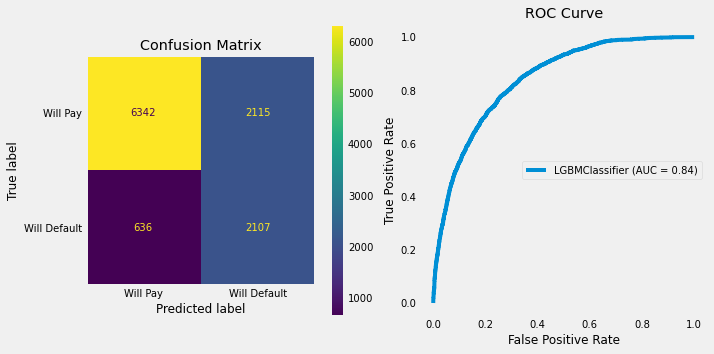

In [317]:
plot_figure(lgm)

In [318]:
print(classification_report(y_test,lgm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.75      0.82      8457
           1       0.50      0.77      0.61      2743

    accuracy                           0.75     11200
   macro avg       0.70      0.76      0.71     11200
weighted avg       0.81      0.75      0.77     11200



In [319]:
test_predictions = lgm.predict_proba(test)[:, 1]

In [320]:
submission = pd.DataFrame({'Applicant_ID' : test_id, 'default_status' : test_predictions})

In [321]:
submission.to_csv('sub.csv', index=False)

### TRIAL 2

In [322]:
from sklearn.model_selection import KFold,StratifiedKFold, StratifiedShuffleSplit
pred_score = []
test_pred = []
splits = None
str_kf = StratifiedKFold(n_splits = 5,shuffle=True,random_state=123)

for train_index,test_index in str_kf.split(X,y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    lgm = LGBMClassifier(silent=True)
    lgm.fit(X_train,y_train, eval_set=[(X_train,y_train),(X_test,y_test)],
           early_stopping_rounds=100, eval_metric='AUC',verbose=True)
    
    pred_score = lgm.predict_proba(X_test)[:,1]
    
    print('Logloss:', log_loss(y_test,pred_score),'*'*30)
    
    p = lgm.predict_proba(test[X.columns])[:,1]
    
    test_pred.append(p)
    

[1]	training's auc: 0.813104	training's binary_logloss: 0.53336	valid_1's auc: 0.801544	valid_1's binary_logloss: 0.534686
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.821152	training's binary_logloss: 0.514778	valid_1's auc: 0.807167	valid_1's binary_logloss: 0.517604
[3]	training's auc: 0.824451	training's binary_logloss: 0.499674	valid_1's auc: 0.810933	valid_1's binary_logloss: 0.503555
[4]	training's auc: 0.828	training's binary_logloss: 0.487012	valid_1's auc: 0.814497	valid_1's binary_logloss: 0.491824
[5]	training's auc: 0.82972	training's binary_logloss: 0.476532	valid_1's auc: 0.81546	valid_1's binary_logloss: 0.48227
[6]	training's auc: 0.832089	training's binary_logloss: 0.46716	valid_1's auc: 0.817971	valid_1's binary_logloss: 0.473666
[7]	training's auc: 0.834676	training's binary_logloss: 0.459095	valid_1's auc: 0.819585	valid_1's binary_logloss: 0.466558
[8]	training's auc: 0.835978	training's binary_logloss: 0.452102	valid_1's auc

[80]	training's auc: 0.884278	training's binary_logloss: 0.360026	valid_1's auc: 0.834852	valid_1's binary_logloss: 0.411485
[81]	training's auc: 0.884923	training's binary_logloss: 0.359359	valid_1's auc: 0.834717	valid_1's binary_logloss: 0.411563
[82]	training's auc: 0.885496	training's binary_logloss: 0.358709	valid_1's auc: 0.834577	valid_1's binary_logloss: 0.411692
[83]	training's auc: 0.885975	training's binary_logloss: 0.358165	valid_1's auc: 0.834614	valid_1's binary_logloss: 0.411659
[84]	training's auc: 0.88654	training's binary_logloss: 0.357643	valid_1's auc: 0.834482	valid_1's binary_logloss: 0.411792
[85]	training's auc: 0.886914	training's binary_logloss: 0.35718	valid_1's auc: 0.834416	valid_1's binary_logloss: 0.411881
[86]	training's auc: 0.887471	training's binary_logloss: 0.356603	valid_1's auc: 0.834367	valid_1's binary_logloss: 0.411909
[87]	training's auc: 0.888076	training's binary_logloss: 0.356008	valid_1's auc: 0.834399	valid_1's binary_logloss: 0.41188
[88

[51]	training's auc: 0.868088	training's binary_logloss: 0.378554	valid_1's auc: 0.839863	valid_1's binary_logloss: 0.406376
[52]	training's auc: 0.868649	training's binary_logloss: 0.377883	valid_1's auc: 0.839766	valid_1's binary_logloss: 0.406427
[53]	training's auc: 0.869242	training's binary_logloss: 0.37725	valid_1's auc: 0.83978	valid_1's binary_logloss: 0.406338
[54]	training's auc: 0.86988	training's binary_logloss: 0.376455	valid_1's auc: 0.839907	valid_1's binary_logloss: 0.406202
[55]	training's auc: 0.870417	training's binary_logloss: 0.375833	valid_1's auc: 0.8399	valid_1's binary_logloss: 0.406179
[56]	training's auc: 0.871049	training's binary_logloss: 0.375129	valid_1's auc: 0.839935	valid_1's binary_logloss: 0.406079
[57]	training's auc: 0.871515	training's binary_logloss: 0.374492	valid_1's auc: 0.84001	valid_1's binary_logloss: 0.405974
[58]	training's auc: 0.872293	training's binary_logloss: 0.37365	valid_1's auc: 0.839987	valid_1's binary_logloss: 0.405952
[59]	tr

[17]	training's auc: 0.844735	training's binary_logloss: 0.417064	valid_1's auc: 0.832995	valid_1's binary_logloss: 0.425505
[18]	training's auc: 0.84579	training's binary_logloss: 0.414577	valid_1's auc: 0.833426	valid_1's binary_logloss: 0.423612
[19]	training's auc: 0.846593	training's binary_logloss: 0.412375	valid_1's auc: 0.833817	valid_1's binary_logloss: 0.421974
[20]	training's auc: 0.847526	training's binary_logloss: 0.410321	valid_1's auc: 0.834485	valid_1's binary_logloss: 0.420347
[21]	training's auc: 0.848246	training's binary_logloss: 0.408453	valid_1's auc: 0.834608	valid_1's binary_logloss: 0.419161
[22]	training's auc: 0.848882	training's binary_logloss: 0.406761	valid_1's auc: 0.83478	valid_1's binary_logloss: 0.418098
[23]	training's auc: 0.849574	training's binary_logloss: 0.405172	valid_1's auc: 0.834973	valid_1's binary_logloss: 0.417059
[24]	training's auc: 0.850338	training's binary_logloss: 0.40362	valid_1's auc: 0.835125	valid_1's binary_logloss: 0.41617
[25]

[93]	training's auc: 0.889181	training's binary_logloss: 0.355108	valid_1's auc: 0.840195	valid_1's binary_logloss: 0.405988
[94]	training's auc: 0.889662	training's binary_logloss: 0.354611	valid_1's auc: 0.840064	valid_1's binary_logloss: 0.406095
[95]	training's auc: 0.890156	training's binary_logloss: 0.354054	valid_1's auc: 0.840041	valid_1's binary_logloss: 0.40606
[96]	training's auc: 0.890505	training's binary_logloss: 0.353694	valid_1's auc: 0.840089	valid_1's binary_logloss: 0.406001
[97]	training's auc: 0.890833	training's binary_logloss: 0.353261	valid_1's auc: 0.840068	valid_1's binary_logloss: 0.406043
[98]	training's auc: 0.891384	training's binary_logloss: 0.352717	valid_1's auc: 0.83991	valid_1's binary_logloss: 0.406165
[99]	training's auc: 0.891809	training's binary_logloss: 0.35223	valid_1's auc: 0.840043	valid_1's binary_logloss: 0.406009
[100]	training's auc: 0.892276	training's binary_logloss: 0.351699	valid_1's auc: 0.839952	valid_1's binary_logloss: 0.40611
Did

[57]	training's auc: 0.872514	training's binary_logloss: 0.373539	valid_1's auc: 0.833231	valid_1's binary_logloss: 0.41243
[58]	training's auc: 0.873027	training's binary_logloss: 0.37297	valid_1's auc: 0.833309	valid_1's binary_logloss: 0.412345
[59]	training's auc: 0.87362	training's binary_logloss: 0.372285	valid_1's auc: 0.833478	valid_1's binary_logloss: 0.412167
[60]	training's auc: 0.874105	training's binary_logloss: 0.371694	valid_1's auc: 0.833625	valid_1's binary_logloss: 0.41206
[61]	training's auc: 0.874662	training's binary_logloss: 0.371136	valid_1's auc: 0.833584	valid_1's binary_logloss: 0.412089
[62]	training's auc: 0.875297	training's binary_logloss: 0.370472	valid_1's auc: 0.833567	valid_1's binary_logloss: 0.412046
[63]	training's auc: 0.875924	training's binary_logloss: 0.369774	valid_1's auc: 0.83363	valid_1's binary_logloss: 0.411979
[64]	training's auc: 0.876431	training's binary_logloss: 0.369235	valid_1's auc: 0.833504	valid_1's binary_logloss: 0.412076
[65]	

[33]	training's auc: 0.856383	training's binary_logloss: 0.392647	valid_1's auc: 0.836194	valid_1's binary_logloss: 0.411546
[34]	training's auc: 0.857075	training's binary_logloss: 0.391673	valid_1's auc: 0.836371	valid_1's binary_logloss: 0.411243
[35]	training's auc: 0.857745	training's binary_logloss: 0.390732	valid_1's auc: 0.836349	valid_1's binary_logloss: 0.411124
[36]	training's auc: 0.858604	training's binary_logloss: 0.389754	valid_1's auc: 0.83654	valid_1's binary_logloss: 0.410789
[37]	training's auc: 0.859299	training's binary_logloss: 0.388806	valid_1's auc: 0.836674	valid_1's binary_logloss: 0.410521
[38]	training's auc: 0.859967	training's binary_logloss: 0.387881	valid_1's auc: 0.836717	valid_1's binary_logloss: 0.410334
[39]	training's auc: 0.86057	training's binary_logloss: 0.387106	valid_1's auc: 0.836819	valid_1's binary_logloss: 0.410137
[40]	training's auc: 0.861193	training's binary_logloss: 0.386302	valid_1's auc: 0.836639	valid_1's binary_logloss: 0.410205
[4

In [323]:
predictions = np.mean(test_pred, axis=0)+np.std(test_pred, axis=0)

In [324]:
predictions

array([0.35533489, 0.47573058, 0.39561733, ..., 0.27577408, 0.55083367,
       0.21734956])

In [325]:
test_pred

[array([0.28557085, 0.44117451, 0.38145638, ..., 0.2253185 , 0.48341214,
        0.11047962]),
 array([0.26162182, 0.43000829, 0.39065116, ..., 0.23751869, 0.55114294,
        0.18708592]),
 array([0.31105485, 0.31692836, 0.38429129, ..., 0.22640825, 0.54017004,
        0.16317354]),
 array([0.39521218, 0.35923574, 0.39945771, ..., 0.27775461, 0.48185452,
        0.25022354]),
 array([0.29487725, 0.50393305, 0.36471384, ..., 0.28418943, 0.54373867,
        0.1369499 ])]

In [326]:
overall_score_minimizing =  np.mean(test_pred)+np.std(test_pred)

In [327]:
overall_score_minimizing

0.4785240979885912

In [328]:
model_auc(lgm)

Train AUC: 0.8931254801422789, Val Auc: 0.8381561484658444


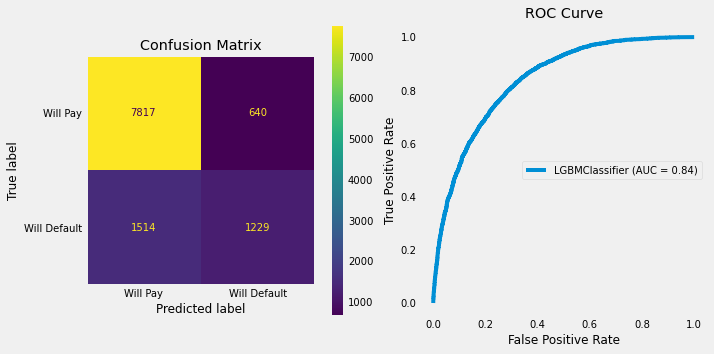

In [329]:
plot_figure(lgm)

In [330]:
print(classification_report(y_test,lgm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      8457
           1       0.66      0.45      0.53      2743

    accuracy                           0.81     11200
   macro avg       0.75      0.69      0.71     11200
weighted avg       0.79      0.81      0.79     11200



In [331]:
test_predictions = lgm.predict_proba(test)[:, 1]

In [332]:
test_predictions.shape

(24000,)

In [333]:
submission = pd.DataFrame({'Applicant_ID' : test_id, 'default_status' : predictions})

In [334]:
submission.to_csv('sub2.csv', index=False)

## TRIAL 3

In [335]:
from catboost import CatBoostClassifier

In [336]:
from sklearn.model_selection import KFold,StratifiedKFold, StratifiedShuffleSplit
pred_score = []
test_pred = []
splits = None
str_kf = StratifiedKFold(n_splits = 5,shuffle=True,random_state=123)

for train_index,test_index in str_kf.split(X,y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    
    cb = CatBoostClassifier(iterations=1900, learning_rate=0.01, l2_leaf_reg=3.5, depth=8, rsm=0.98, loss_function= 'Logloss', eval_metric='AUC',use_best_model=True,random_seed=52)
    cb.fit(X_train,y_train, eval_set=[(X_train,y_train),(X_test,y_test)],
           early_stopping_rounds=100,verbose=True)
    
    pred_score = cb.predict_proba(X_test)[:,1]
    
    print('Logloss:', log_loss(y_test,pred_score),'*'*30)
    
    p = cb.predict_proba(test[X.columns])[:,1]
    
    test_pred.append(p)
    

0:	test: 0.8007506	test1: 0.7926582	best: 0.7926582 (0)	total: 58.1ms	remaining: 1m 50s
1:	test: 0.8166357	test1: 0.8085949	best: 0.8085949 (1)	total: 93.6ms	remaining: 1m 28s
2:	test: 0.8212384	test1: 0.8127220	best: 0.8127220 (2)	total: 130ms	remaining: 1m 22s
3:	test: 0.8222992	test1: 0.8129711	best: 0.8129711 (3)	total: 171ms	remaining: 1m 21s
4:	test: 0.8228914	test1: 0.8135625	best: 0.8135625 (4)	total: 211ms	remaining: 1m 20s
5:	test: 0.8254160	test1: 0.8159445	best: 0.8159445 (5)	total: 245ms	remaining: 1m 17s
6:	test: 0.8256287	test1: 0.8158533	best: 0.8159445 (5)	total: 283ms	remaining: 1m 16s
7:	test: 0.8255255	test1: 0.8158893	best: 0.8159445 (5)	total: 317ms	remaining: 1m 14s
8:	test: 0.8258016	test1: 0.8166120	best: 0.8166120 (8)	total: 352ms	remaining: 1m 14s
9:	test: 0.8262119	test1: 0.8170020	best: 0.8170020 (9)	total: 391ms	remaining: 1m 13s
10:	test: 0.8262328	test1: 0.8169771	best: 0.8170020 (9)	total: 425ms	remaining: 1m 13s
11:	test: 0.8264325	test1: 0.8173124	bes

96:	test: 0.8364270	test1: 0.8255153	best: 0.8255153 (96)	total: 3.77s	remaining: 1m 10s
97:	test: 0.8365139	test1: 0.8255619	best: 0.8255619 (97)	total: 3.82s	remaining: 1m 10s
98:	test: 0.8366369	test1: 0.8256942	best: 0.8256942 (98)	total: 3.86s	remaining: 1m 10s
99:	test: 0.8366890	test1: 0.8257211	best: 0.8257211 (99)	total: 3.9s	remaining: 1m 10s
100:	test: 0.8367388	test1: 0.8257247	best: 0.8257247 (100)	total: 3.93s	remaining: 1m 10s
101:	test: 0.8368079	test1: 0.8257498	best: 0.8257498 (101)	total: 3.97s	remaining: 1m 9s
102:	test: 0.8369492	test1: 0.8258281	best: 0.8258281 (102)	total: 4s	remaining: 1m 9s
103:	test: 0.8369931	test1: 0.8258728	best: 0.8258728 (103)	total: 4.05s	remaining: 1m 10s
104:	test: 0.8371086	test1: 0.8259589	best: 0.8259589 (104)	total: 4.09s	remaining: 1m 9s
105:	test: 0.8371568	test1: 0.8260241	best: 0.8260241 (105)	total: 4.12s	remaining: 1m 9s
106:	test: 0.8372636	test1: 0.8260951	best: 0.8260951 (106)	total: 4.17s	remaining: 1m 9s
107:	test: 0.837

192:	test: 0.8430079	test1: 0.8302724	best: 0.8302724 (192)	total: 7.26s	remaining: 1m 4s
193:	test: 0.8430689	test1: 0.8302935	best: 0.8302935 (193)	total: 7.29s	remaining: 1m 4s
194:	test: 0.8431199	test1: 0.8303170	best: 0.8303170 (194)	total: 7.33s	remaining: 1m 4s
195:	test: 0.8431677	test1: 0.8303400	best: 0.8303400 (195)	total: 7.36s	remaining: 1m 3s
196:	test: 0.8432205	test1: 0.8303941	best: 0.8303941 (196)	total: 7.39s	remaining: 1m 3s
197:	test: 0.8432789	test1: 0.8304430	best: 0.8304430 (197)	total: 7.42s	remaining: 1m 3s
198:	test: 0.8433394	test1: 0.8304734	best: 0.8304734 (198)	total: 7.47s	remaining: 1m 3s
199:	test: 0.8433997	test1: 0.8305106	best: 0.8305106 (199)	total: 7.5s	remaining: 1m 3s
200:	test: 0.8434676	test1: 0.8305491	best: 0.8305491 (200)	total: 7.53s	remaining: 1m 3s
201:	test: 0.8435154	test1: 0.8306231	best: 0.8306231 (201)	total: 7.56s	remaining: 1m 3s
202:	test: 0.8435532	test1: 0.8306479	best: 0.8306479 (202)	total: 7.59s	remaining: 1m 3s
203:	test: 

288:	test: 0.8480247	test1: 0.8329210	best: 0.8329210 (288)	total: 10.7s	remaining: 59.8s
289:	test: 0.8480635	test1: 0.8329494	best: 0.8329494 (289)	total: 10.8s	remaining: 59.7s
290:	test: 0.8481174	test1: 0.8329653	best: 0.8329653 (290)	total: 10.8s	remaining: 59.7s
291:	test: 0.8481674	test1: 0.8329840	best: 0.8329840 (291)	total: 10.8s	remaining: 59.7s
292:	test: 0.8481840	test1: 0.8329960	best: 0.8329960 (292)	total: 10.9s	remaining: 59.6s
293:	test: 0.8482320	test1: 0.8330166	best: 0.8330166 (293)	total: 10.9s	remaining: 59.5s
294:	test: 0.8482846	test1: 0.8330197	best: 0.8330197 (294)	total: 10.9s	remaining: 59.5s
295:	test: 0.8483190	test1: 0.8330396	best: 0.8330396 (295)	total: 11s	remaining: 59.4s
296:	test: 0.8483615	test1: 0.8330598	best: 0.8330598 (296)	total: 11s	remaining: 59.4s
297:	test: 0.8484208	test1: 0.8330961	best: 0.8330961 (297)	total: 11s	remaining: 59.3s
298:	test: 0.8484511	test1: 0.8330934	best: 0.8330961 (297)	total: 11.1s	remaining: 59.3s
299:	test: 0.848

384:	test: 0.8522719	test1: 0.8344022	best: 0.8344022 (384)	total: 14.1s	remaining: 55.4s
385:	test: 0.8523095	test1: 0.8344182	best: 0.8344182 (385)	total: 14.1s	remaining: 55.4s
386:	test: 0.8523496	test1: 0.8344334	best: 0.8344334 (386)	total: 14.2s	remaining: 55.3s
387:	test: 0.8524234	test1: 0.8344378	best: 0.8344378 (387)	total: 14.2s	remaining: 55.3s
388:	test: 0.8524743	test1: 0.8344493	best: 0.8344493 (388)	total: 14.2s	remaining: 55.2s
389:	test: 0.8525250	test1: 0.8344708	best: 0.8344708 (389)	total: 14.3s	remaining: 55.2s
390:	test: 0.8525611	test1: 0.8344735	best: 0.8344735 (390)	total: 14.3s	remaining: 55.2s
391:	test: 0.8526157	test1: 0.8344850	best: 0.8344850 (391)	total: 14.3s	remaining: 55.2s
392:	test: 0.8526572	test1: 0.8344879	best: 0.8344879 (392)	total: 14.4s	remaining: 55.1s
393:	test: 0.8526984	test1: 0.8345177	best: 0.8345177 (393)	total: 14.4s	remaining: 55.1s
394:	test: 0.8527520	test1: 0.8345170	best: 0.8345177 (393)	total: 14.4s	remaining: 55s
395:	test: 0

482:	test: 0.8565052	test1: 0.8356149	best: 0.8356149 (482)	total: 17.6s	remaining: 51.7s
483:	test: 0.8565422	test1: 0.8356260	best: 0.8356260 (483)	total: 17.7s	remaining: 51.7s
484:	test: 0.8565781	test1: 0.8356226	best: 0.8356260 (483)	total: 17.7s	remaining: 51.6s
485:	test: 0.8566236	test1: 0.8356292	best: 0.8356292 (485)	total: 17.7s	remaining: 51.6s
486:	test: 0.8566534	test1: 0.8356479	best: 0.8356479 (486)	total: 17.8s	remaining: 51.6s
487:	test: 0.8566897	test1: 0.8356631	best: 0.8356631 (487)	total: 17.8s	remaining: 51.5s
488:	test: 0.8567608	test1: 0.8356760	best: 0.8356760 (488)	total: 17.8s	remaining: 51.5s
489:	test: 0.8568011	test1: 0.8356925	best: 0.8356925 (489)	total: 17.9s	remaining: 51.4s
490:	test: 0.8568354	test1: 0.8357072	best: 0.8357072 (490)	total: 17.9s	remaining: 51.4s
491:	test: 0.8568762	test1: 0.8357186	best: 0.8357186 (491)	total: 18s	remaining: 51.4s
492:	test: 0.8569158	test1: 0.8357210	best: 0.8357210 (492)	total: 18s	remaining: 51.4s
493:	test: 0.8

576:	test: 0.8600427	test1: 0.8364491	best: 0.8364491 (576)	total: 20.9s	remaining: 47.9s
577:	test: 0.8600914	test1: 0.8364572	best: 0.8364572 (577)	total: 20.9s	remaining: 47.9s
578:	test: 0.8601196	test1: 0.8364695	best: 0.8364695 (578)	total: 21s	remaining: 47.8s
579:	test: 0.8601620	test1: 0.8364635	best: 0.8364695 (578)	total: 21s	remaining: 47.8s
580:	test: 0.8601874	test1: 0.8364662	best: 0.8364695 (578)	total: 21s	remaining: 47.8s
581:	test: 0.8602065	test1: 0.8364712	best: 0.8364712 (581)	total: 21.1s	remaining: 47.7s
582:	test: 0.8602515	test1: 0.8364749	best: 0.8364749 (582)	total: 21.1s	remaining: 47.7s
583:	test: 0.8602765	test1: 0.8364809	best: 0.8364809 (583)	total: 21.1s	remaining: 47.6s
584:	test: 0.8603167	test1: 0.8364999	best: 0.8364999 (584)	total: 21.2s	remaining: 47.6s
585:	test: 0.8603530	test1: 0.8364947	best: 0.8364999 (584)	total: 21.2s	remaining: 47.6s
586:	test: 0.8604222	test1: 0.8364938	best: 0.8364999 (584)	total: 21.2s	remaining: 47.5s
587:	test: 0.860

671:	test: 0.8633998	test1: 0.8371605	best: 0.8371605 (671)	total: 24.3s	remaining: 44.3s
672:	test: 0.8634377	test1: 0.8371669	best: 0.8371669 (672)	total: 24.3s	remaining: 44.3s
673:	test: 0.8635014	test1: 0.8371610	best: 0.8371669 (672)	total: 24.3s	remaining: 44.3s
674:	test: 0.8635158	test1: 0.8371598	best: 0.8371669 (672)	total: 24.4s	remaining: 44.2s
675:	test: 0.8635527	test1: 0.8371794	best: 0.8371794 (675)	total: 24.4s	remaining: 44.2s
676:	test: 0.8635752	test1: 0.8371907	best: 0.8371907 (676)	total: 24.4s	remaining: 44.1s
677:	test: 0.8636047	test1: 0.8372008	best: 0.8372008 (677)	total: 24.5s	remaining: 44.1s
678:	test: 0.8636276	test1: 0.8371989	best: 0.8372008 (677)	total: 24.5s	remaining: 44.1s
679:	test: 0.8636596	test1: 0.8371974	best: 0.8372008 (677)	total: 24.5s	remaining: 44s
680:	test: 0.8636832	test1: 0.8372002	best: 0.8372008 (677)	total: 24.6s	remaining: 44s
681:	test: 0.8637195	test1: 0.8372082	best: 0.8372082 (681)	total: 24.6s	remaining: 43.9s
682:	test: 0.8

764:	test: 0.8666664	test1: 0.8376203	best: 0.8376203 (764)	total: 27.6s	remaining: 41s
765:	test: 0.8666757	test1: 0.8376276	best: 0.8376276 (765)	total: 27.6s	remaining: 40.9s
766:	test: 0.8666940	test1: 0.8376349	best: 0.8376349 (766)	total: 27.7s	remaining: 40.9s
767:	test: 0.8667262	test1: 0.8376425	best: 0.8376425 (767)	total: 27.7s	remaining: 40.9s
768:	test: 0.8667572	test1: 0.8376522	best: 0.8376522 (768)	total: 27.8s	remaining: 40.8s
769:	test: 0.8667847	test1: 0.8376555	best: 0.8376555 (769)	total: 27.8s	remaining: 40.8s
770:	test: 0.8668044	test1: 0.8376616	best: 0.8376616 (770)	total: 27.8s	remaining: 40.7s
771:	test: 0.8668351	test1: 0.8376619	best: 0.8376619 (771)	total: 27.9s	remaining: 40.7s
772:	test: 0.8668599	test1: 0.8376746	best: 0.8376746 (772)	total: 27.9s	remaining: 40.7s
773:	test: 0.8668873	test1: 0.8376798	best: 0.8376798 (773)	total: 27.9s	remaining: 40.6s
774:	test: 0.8669185	test1: 0.8376761	best: 0.8376798 (773)	total: 28s	remaining: 40.6s
775:	test: 0.8

859:	test: 0.8696513	test1: 0.8380296	best: 0.8380329 (858)	total: 31s	remaining: 37.5s
860:	test: 0.8696891	test1: 0.8380329	best: 0.8380329 (860)	total: 31s	remaining: 37.5s
861:	test: 0.8697254	test1: 0.8380407	best: 0.8380407 (861)	total: 31.1s	remaining: 37.4s
862:	test: 0.8697582	test1: 0.8380407	best: 0.8380407 (861)	total: 31.1s	remaining: 37.4s
863:	test: 0.8697997	test1: 0.8380453	best: 0.8380453 (863)	total: 31.1s	remaining: 37.3s
864:	test: 0.8698592	test1: 0.8380567	best: 0.8380567 (864)	total: 31.2s	remaining: 37.3s
865:	test: 0.8699127	test1: 0.8380666	best: 0.8380666 (865)	total: 31.2s	remaining: 37.3s
866:	test: 0.8699393	test1: 0.8380660	best: 0.8380666 (865)	total: 31.3s	remaining: 37.2s
867:	test: 0.8699812	test1: 0.8380663	best: 0.8380666 (865)	total: 31.3s	remaining: 37.2s
868:	test: 0.8700134	test1: 0.8380717	best: 0.8380717 (868)	total: 31.3s	remaining: 37.2s
869:	test: 0.8700555	test1: 0.8380712	best: 0.8380717 (868)	total: 31.4s	remaining: 37.1s
870:	test: 0.8

952:	test: 0.8728865	test1: 0.8383973	best: 0.8383973 (952)	total: 34.3s	remaining: 34.1s
953:	test: 0.8729072	test1: 0.8383988	best: 0.8383988 (953)	total: 34.3s	remaining: 34s
954:	test: 0.8729405	test1: 0.8383921	best: 0.8383988 (953)	total: 34.3s	remaining: 34s
955:	test: 0.8729686	test1: 0.8383944	best: 0.8383988 (953)	total: 34.4s	remaining: 34s
956:	test: 0.8729984	test1: 0.8384043	best: 0.8384043 (956)	total: 34.4s	remaining: 33.9s
957:	test: 0.8730186	test1: 0.8384137	best: 0.8384137 (957)	total: 34.5s	remaining: 33.9s
958:	test: 0.8730496	test1: 0.8384090	best: 0.8384137 (957)	total: 34.5s	remaining: 33.8s
959:	test: 0.8731065	test1: 0.8384281	best: 0.8384281 (959)	total: 34.5s	remaining: 33.8s
960:	test: 0.8731482	test1: 0.8384403	best: 0.8384403 (960)	total: 34.5s	remaining: 33.8s
961:	test: 0.8731714	test1: 0.8384408	best: 0.8384408 (961)	total: 34.6s	remaining: 33.7s
962:	test: 0.8732130	test1: 0.8384334	best: 0.8384408 (961)	total: 34.6s	remaining: 33.7s
963:	test: 0.873

1047:	test: 0.8758744	test1: 0.8386758	best: 0.8386806 (1045)	total: 37.6s	remaining: 30.6s
1048:	test: 0.8758978	test1: 0.8386685	best: 0.8386806 (1045)	total: 37.7s	remaining: 30.6s
1049:	test: 0.8759375	test1: 0.8386722	best: 0.8386806 (1045)	total: 37.7s	remaining: 30.5s
1050:	test: 0.8759681	test1: 0.8386609	best: 0.8386806 (1045)	total: 37.7s	remaining: 30.5s
1051:	test: 0.8760241	test1: 0.8386659	best: 0.8386806 (1045)	total: 37.8s	remaining: 30.4s
1052:	test: 0.8760588	test1: 0.8386677	best: 0.8386806 (1045)	total: 37.8s	remaining: 30.4s
1053:	test: 0.8760933	test1: 0.8386738	best: 0.8386806 (1045)	total: 37.8s	remaining: 30.4s
1054:	test: 0.8761119	test1: 0.8386724	best: 0.8386806 (1045)	total: 37.9s	remaining: 30.3s
1055:	test: 0.8761565	test1: 0.8386756	best: 0.8386806 (1045)	total: 37.9s	remaining: 30.3s
1056:	test: 0.8761821	test1: 0.8386818	best: 0.8386818 (1056)	total: 37.9s	remaining: 30.3s
1057:	test: 0.8762269	test1: 0.8386803	best: 0.8386818 (1056)	total: 38s	remaini

1138:	test: 0.8790713	test1: 0.8388626	best: 0.8388626 (1138)	total: 40.8s	remaining: 27.3s
1139:	test: 0.8791045	test1: 0.8388702	best: 0.8388702 (1139)	total: 40.9s	remaining: 27.2s
1140:	test: 0.8791598	test1: 0.8388588	best: 0.8388702 (1139)	total: 40.9s	remaining: 27.2s
1141:	test: 0.8792072	test1: 0.8388553	best: 0.8388702 (1139)	total: 40.9s	remaining: 27.2s
1142:	test: 0.8792345	test1: 0.8388624	best: 0.8388702 (1139)	total: 41s	remaining: 27.1s
1143:	test: 0.8792973	test1: 0.8388737	best: 0.8388737 (1143)	total: 41s	remaining: 27.1s
1144:	test: 0.8793331	test1: 0.8388727	best: 0.8388737 (1143)	total: 41s	remaining: 27.1s
1145:	test: 0.8793890	test1: 0.8388889	best: 0.8388889 (1145)	total: 41.1s	remaining: 27s
1146:	test: 0.8794156	test1: 0.8389060	best: 0.8389060 (1146)	total: 41.1s	remaining: 27s
1147:	test: 0.8794426	test1: 0.8389148	best: 0.8389148 (1147)	total: 41.1s	remaining: 27s
1148:	test: 0.8794749	test1: 0.8389024	best: 0.8389148 (1147)	total: 41.2s	remaining: 26.9s


1228:	test: 0.8822394	test1: 0.8391388	best: 0.8391455 (1227)	total: 44s	remaining: 24s
1229:	test: 0.8822662	test1: 0.8391511	best: 0.8391511 (1229)	total: 44s	remaining: 24s
1230:	test: 0.8822885	test1: 0.8391524	best: 0.8391524 (1230)	total: 44.1s	remaining: 24s
1231:	test: 0.8823106	test1: 0.8391541	best: 0.8391541 (1231)	total: 44.1s	remaining: 23.9s
1232:	test: 0.8823351	test1: 0.8391552	best: 0.8391552 (1232)	total: 44.2s	remaining: 23.9s
1233:	test: 0.8823701	test1: 0.8391570	best: 0.8391570 (1233)	total: 44.2s	remaining: 23.9s
1234:	test: 0.8823987	test1: 0.8391572	best: 0.8391572 (1234)	total: 44.2s	remaining: 23.8s
1235:	test: 0.8824163	test1: 0.8391627	best: 0.8391627 (1235)	total: 44.3s	remaining: 23.8s
1236:	test: 0.8824736	test1: 0.8391765	best: 0.8391765 (1236)	total: 44.3s	remaining: 23.7s
1237:	test: 0.8825175	test1: 0.8391728	best: 0.8391765 (1236)	total: 44.3s	remaining: 23.7s
1238:	test: 0.8825593	test1: 0.8391637	best: 0.8391765 (1236)	total: 44.4s	remaining: 23.7

1318:	test: 0.8852229	test1: 0.8392675	best: 0.8392830 (1299)	total: 47.2s	remaining: 20.8s
1319:	test: 0.8852857	test1: 0.8392656	best: 0.8392830 (1299)	total: 47.2s	remaining: 20.8s
1320:	test: 0.8853304	test1: 0.8392689	best: 0.8392830 (1299)	total: 47.3s	remaining: 20.7s
1321:	test: 0.8853759	test1: 0.8392594	best: 0.8392830 (1299)	total: 47.3s	remaining: 20.7s
1322:	test: 0.8854102	test1: 0.8392787	best: 0.8392830 (1299)	total: 47.4s	remaining: 20.7s
1323:	test: 0.8854393	test1: 0.8392782	best: 0.8392830 (1299)	total: 47.4s	remaining: 20.6s
1324:	test: 0.8854586	test1: 0.8392767	best: 0.8392830 (1299)	total: 47.4s	remaining: 20.6s
1325:	test: 0.8854992	test1: 0.8392871	best: 0.8392871 (1325)	total: 47.5s	remaining: 20.5s
1326:	test: 0.8855347	test1: 0.8392847	best: 0.8392871 (1325)	total: 47.5s	remaining: 20.5s
1327:	test: 0.8855698	test1: 0.8392804	best: 0.8392871 (1325)	total: 47.5s	remaining: 20.5s
1328:	test: 0.8855975	test1: 0.8392760	best: 0.8392871 (1325)	total: 47.6s	remai

1412:	test: 0.8883624	test1: 0.8394192	best: 0.8394352 (1399)	total: 50.5s	remaining: 17.4s
1413:	test: 0.8883936	test1: 0.8394334	best: 0.8394352 (1399)	total: 50.5s	remaining: 17.4s
1414:	test: 0.8884169	test1: 0.8394352	best: 0.8394352 (1399)	total: 50.6s	remaining: 17.3s
1415:	test: 0.8884615	test1: 0.8394346	best: 0.8394352 (1399)	total: 50.6s	remaining: 17.3s
1416:	test: 0.8884914	test1: 0.8394356	best: 0.8394356 (1416)	total: 50.7s	remaining: 17.3s
1417:	test: 0.8885132	test1: 0.8394397	best: 0.8394397 (1417)	total: 50.7s	remaining: 17.2s
1418:	test: 0.8885600	test1: 0.8394387	best: 0.8394397 (1417)	total: 50.7s	remaining: 17.2s
1419:	test: 0.8885894	test1: 0.8394395	best: 0.8394397 (1417)	total: 50.8s	remaining: 17.2s
1420:	test: 0.8886288	test1: 0.8394567	best: 0.8394567 (1420)	total: 50.8s	remaining: 17.1s
1421:	test: 0.8886716	test1: 0.8394458	best: 0.8394567 (1420)	total: 50.8s	remaining: 17.1s
1422:	test: 0.8886996	test1: 0.8394381	best: 0.8394567 (1420)	total: 50.9s	remai

1505:	test: 0.8913397	test1: 0.8394318	best: 0.8394747 (1456)	total: 53.7s	remaining: 14.1s
1506:	test: 0.8913673	test1: 0.8394296	best: 0.8394747 (1456)	total: 53.8s	remaining: 14s
1507:	test: 0.8913922	test1: 0.8394340	best: 0.8394747 (1456)	total: 53.8s	remaining: 14s
1508:	test: 0.8914226	test1: 0.8394312	best: 0.8394747 (1456)	total: 53.8s	remaining: 13.9s
1509:	test: 0.8914516	test1: 0.8394218	best: 0.8394747 (1456)	total: 53.9s	remaining: 13.9s
1510:	test: 0.8914825	test1: 0.8394178	best: 0.8394747 (1456)	total: 53.9s	remaining: 13.9s
1511:	test: 0.8915155	test1: 0.8394101	best: 0.8394747 (1456)	total: 53.9s	remaining: 13.8s
1512:	test: 0.8915442	test1: 0.8393972	best: 0.8394747 (1456)	total: 54s	remaining: 13.8s
1513:	test: 0.8915758	test1: 0.8393986	best: 0.8394747 (1456)	total: 54s	remaining: 13.8s
1514:	test: 0.8916057	test1: 0.8393946	best: 0.8394747 (1456)	total: 54s	remaining: 13.7s
1515:	test: 0.8916353	test1: 0.8393983	best: 0.8394747 (1456)	total: 54.1s	remaining: 13.7

40:	test: 0.8302163	test1: 0.8241062	best: 0.8241062 (40)	total: 1.69s	remaining: 1m 16s
41:	test: 0.8303530	test1: 0.8242222	best: 0.8242222 (41)	total: 1.74s	remaining: 1m 17s
42:	test: 0.8307446	test1: 0.8244367	best: 0.8244367 (42)	total: 1.78s	remaining: 1m 16s
43:	test: 0.8307663	test1: 0.8244081	best: 0.8244367 (42)	total: 1.81s	remaining: 1m 16s
44:	test: 0.8308480	test1: 0.8245002	best: 0.8245002 (44)	total: 1.84s	remaining: 1m 16s
45:	test: 0.8311936	test1: 0.8249283	best: 0.8249283 (45)	total: 1.89s	remaining: 1m 16s
46:	test: 0.8313086	test1: 0.8249770	best: 0.8249770 (46)	total: 1.92s	remaining: 1m 15s
47:	test: 0.8314888	test1: 0.8251168	best: 0.8251168 (47)	total: 1.96s	remaining: 1m 15s
48:	test: 0.8316803	test1: 0.8252402	best: 0.8252402 (48)	total: 1.99s	remaining: 1m 15s
49:	test: 0.8318162	test1: 0.8253857	best: 0.8253857 (49)	total: 2.03s	remaining: 1m 15s
50:	test: 0.8320169	test1: 0.8254783	best: 0.8254783 (50)	total: 2.08s	remaining: 1m 15s
51:	test: 0.8320592	t

136:	test: 0.8399546	test1: 0.8311694	best: 0.8311694 (136)	total: 5.25s	remaining: 1m 7s
137:	test: 0.8399862	test1: 0.8312235	best: 0.8312235 (137)	total: 5.28s	remaining: 1m 7s
138:	test: 0.8400541	test1: 0.8312713	best: 0.8312713 (138)	total: 5.32s	remaining: 1m 7s
139:	test: 0.8401411	test1: 0.8312898	best: 0.8312898 (139)	total: 5.35s	remaining: 1m 7s
140:	test: 0.8402191	test1: 0.8312690	best: 0.8312898 (139)	total: 5.39s	remaining: 1m 7s
141:	test: 0.8402720	test1: 0.8313184	best: 0.8313184 (141)	total: 5.42s	remaining: 1m 7s
142:	test: 0.8403627	test1: 0.8313886	best: 0.8313886 (142)	total: 5.46s	remaining: 1m 7s
143:	test: 0.8404407	test1: 0.8314250	best: 0.8314250 (143)	total: 5.49s	remaining: 1m 7s
144:	test: 0.8404909	test1: 0.8314417	best: 0.8314417 (144)	total: 5.53s	remaining: 1m 6s
145:	test: 0.8405383	test1: 0.8314517	best: 0.8314517 (145)	total: 5.56s	remaining: 1m 6s
146:	test: 0.8405757	test1: 0.8314832	best: 0.8314832 (146)	total: 5.61s	remaining: 1m 6s
147:	test:

228:	test: 0.8449393	test1: 0.8339645	best: 0.8339645 (228)	total: 8.59s	remaining: 1m 2s
229:	test: 0.8449843	test1: 0.8339888	best: 0.8339888 (229)	total: 8.62s	remaining: 1m 2s
230:	test: 0.8450234	test1: 0.8340065	best: 0.8340065 (230)	total: 8.65s	remaining: 1m 2s
231:	test: 0.8450647	test1: 0.8340172	best: 0.8340172 (231)	total: 8.69s	remaining: 1m 2s
232:	test: 0.8451299	test1: 0.8340375	best: 0.8340375 (232)	total: 8.72s	remaining: 1m 2s
233:	test: 0.8451725	test1: 0.8340730	best: 0.8340730 (233)	total: 8.76s	remaining: 1m 2s
234:	test: 0.8452473	test1: 0.8340774	best: 0.8340774 (234)	total: 8.8s	remaining: 1m 2s
235:	test: 0.8453031	test1: 0.8341109	best: 0.8341109 (235)	total: 8.83s	remaining: 1m 2s
236:	test: 0.8453675	test1: 0.8341591	best: 0.8341591 (236)	total: 8.87s	remaining: 1m 2s
237:	test: 0.8454224	test1: 0.8341720	best: 0.8341720 (237)	total: 8.9s	remaining: 1m 2s
238:	test: 0.8454669	test1: 0.8341920	best: 0.8341920 (238)	total: 8.93s	remaining: 1m 2s
239:	test: 0

325:	test: 0.8495715	test1: 0.8358918	best: 0.8358918 (325)	total: 12.1s	remaining: 58.5s
326:	test: 0.8496190	test1: 0.8358888	best: 0.8358918 (325)	total: 12.2s	remaining: 58.5s
327:	test: 0.8496359	test1: 0.8359142	best: 0.8359142 (327)	total: 12.2s	remaining: 58.4s
328:	test: 0.8496924	test1: 0.8359460	best: 0.8359460 (328)	total: 12.2s	remaining: 58.4s
329:	test: 0.8497348	test1: 0.8359533	best: 0.8359533 (329)	total: 12.3s	remaining: 58.3s
330:	test: 0.8497672	test1: 0.8359744	best: 0.8359744 (330)	total: 12.3s	remaining: 58.2s
331:	test: 0.8498024	test1: 0.8359869	best: 0.8359869 (331)	total: 12.3s	remaining: 58.2s
332:	test: 0.8498475	test1: 0.8360127	best: 0.8360127 (332)	total: 12.4s	remaining: 58.1s
333:	test: 0.8498894	test1: 0.8360284	best: 0.8360284 (333)	total: 12.4s	remaining: 58.1s
334:	test: 0.8499398	test1: 0.8360588	best: 0.8360588 (334)	total: 12.4s	remaining: 58s
335:	test: 0.8499758	test1: 0.8360711	best: 0.8360711 (335)	total: 12.5s	remaining: 58s
336:	test: 0.8

419:	test: 0.8534954	test1: 0.8372792	best: 0.8372792 (419)	total: 15.4s	remaining: 54.3s
420:	test: 0.8535507	test1: 0.8372989	best: 0.8372989 (420)	total: 15.5s	remaining: 54.3s
421:	test: 0.8535857	test1: 0.8373188	best: 0.8373188 (421)	total: 15.5s	remaining: 54.3s
422:	test: 0.8536386	test1: 0.8373427	best: 0.8373427 (422)	total: 15.5s	remaining: 54.2s
423:	test: 0.8536670	test1: 0.8373545	best: 0.8373545 (423)	total: 15.6s	remaining: 54.2s
424:	test: 0.8537135	test1: 0.8373639	best: 0.8373639 (424)	total: 15.6s	remaining: 54.1s
425:	test: 0.8537600	test1: 0.8373874	best: 0.8373874 (425)	total: 15.6s	remaining: 54.1s
426:	test: 0.8538112	test1: 0.8373918	best: 0.8373918 (426)	total: 15.7s	remaining: 54.1s
427:	test: 0.8538742	test1: 0.8374032	best: 0.8374032 (427)	total: 15.7s	remaining: 54s
428:	test: 0.8539159	test1: 0.8374137	best: 0.8374137 (428)	total: 15.7s	remaining: 54s
429:	test: 0.8539726	test1: 0.8374337	best: 0.8374337 (429)	total: 15.8s	remaining: 54s
430:	test: 0.854

512:	test: 0.8573797	test1: 0.8384159	best: 0.8384159 (512)	total: 18.8s	remaining: 50.8s
513:	test: 0.8574112	test1: 0.8384270	best: 0.8384270 (513)	total: 18.8s	remaining: 50.7s
514:	test: 0.8574782	test1: 0.8384708	best: 0.8384708 (514)	total: 18.8s	remaining: 50.7s
515:	test: 0.8575016	test1: 0.8384704	best: 0.8384708 (514)	total: 18.9s	remaining: 50.6s
516:	test: 0.8575424	test1: 0.8384910	best: 0.8384910 (516)	total: 18.9s	remaining: 50.6s
517:	test: 0.8575893	test1: 0.8384955	best: 0.8384955 (517)	total: 18.9s	remaining: 50.5s
518:	test: 0.8576236	test1: 0.8384890	best: 0.8384955 (517)	total: 19s	remaining: 50.5s
519:	test: 0.8576816	test1: 0.8384760	best: 0.8384955 (517)	total: 19s	remaining: 50.5s
520:	test: 0.8577184	test1: 0.8384811	best: 0.8384955 (517)	total: 19.1s	remaining: 50.4s
521:	test: 0.8577428	test1: 0.8384861	best: 0.8384955 (517)	total: 19.1s	remaining: 50.4s
522:	test: 0.8578092	test1: 0.8385000	best: 0.8385000 (522)	total: 19.1s	remaining: 50.4s
523:	test: 0.8

604:	test: 0.8607628	test1: 0.8391667	best: 0.8391667 (604)	total: 22.1s	remaining: 47.3s
605:	test: 0.8608001	test1: 0.8391797	best: 0.8391797 (605)	total: 22.1s	remaining: 47.2s
606:	test: 0.8608564	test1: 0.8392021	best: 0.8392021 (606)	total: 22.2s	remaining: 47.2s
607:	test: 0.8608905	test1: 0.8392178	best: 0.8392178 (607)	total: 22.2s	remaining: 47.2s
608:	test: 0.8609417	test1: 0.8392373	best: 0.8392373 (608)	total: 22.2s	remaining: 47.1s
609:	test: 0.8609800	test1: 0.8392470	best: 0.8392470 (609)	total: 22.3s	remaining: 47.1s
610:	test: 0.8610069	test1: 0.8392554	best: 0.8392554 (610)	total: 22.3s	remaining: 47s
611:	test: 0.8610201	test1: 0.8392539	best: 0.8392554 (610)	total: 22.3s	remaining: 47s
612:	test: 0.8610603	test1: 0.8392542	best: 0.8392554 (610)	total: 22.4s	remaining: 47s
613:	test: 0.8610893	test1: 0.8392656	best: 0.8392656 (613)	total: 22.4s	remaining: 46.9s
614:	test: 0.8611545	test1: 0.8392826	best: 0.8392826 (614)	total: 22.4s	remaining: 46.9s
615:	test: 0.861

697:	test: 0.8639813	test1: 0.8398475	best: 0.8398475 (697)	total: 25.5s	remaining: 43.9s
698:	test: 0.8640121	test1: 0.8398462	best: 0.8398475 (697)	total: 25.5s	remaining: 43.9s
699:	test: 0.8640415	test1: 0.8398594	best: 0.8398594 (699)	total: 25.6s	remaining: 43.9s
700:	test: 0.8640895	test1: 0.8398624	best: 0.8398624 (700)	total: 25.6s	remaining: 43.8s
701:	test: 0.8641227	test1: 0.8398737	best: 0.8398737 (701)	total: 25.6s	remaining: 43.8s
702:	test: 0.8641776	test1: 0.8398693	best: 0.8398737 (701)	total: 25.7s	remaining: 43.7s
703:	test: 0.8642229	test1: 0.8398793	best: 0.8398793 (703)	total: 25.7s	remaining: 43.7s
704:	test: 0.8642782	test1: 0.8398860	best: 0.8398860 (704)	total: 25.8s	remaining: 43.7s
705:	test: 0.8643095	test1: 0.8398960	best: 0.8398960 (705)	total: 25.8s	remaining: 43.6s
706:	test: 0.8643800	test1: 0.8399096	best: 0.8399096 (706)	total: 25.8s	remaining: 43.6s
707:	test: 0.8644268	test1: 0.8399159	best: 0.8399159 (707)	total: 25.9s	remaining: 43.6s
708:	test:

792:	test: 0.8672890	test1: 0.8403828	best: 0.8403828 (792)	total: 29s	remaining: 40.4s
793:	test: 0.8673313	test1: 0.8403758	best: 0.8403828 (792)	total: 29s	remaining: 40.4s
794:	test: 0.8673817	test1: 0.8403772	best: 0.8403828 (792)	total: 29s	remaining: 40.3s
795:	test: 0.8674249	test1: 0.8403883	best: 0.8403883 (795)	total: 29.1s	remaining: 40.3s
796:	test: 0.8674621	test1: 0.8403875	best: 0.8403883 (795)	total: 29.1s	remaining: 40.3s
797:	test: 0.8674922	test1: 0.8403934	best: 0.8403934 (797)	total: 29.1s	remaining: 40.3s
798:	test: 0.8675133	test1: 0.8404004	best: 0.8404004 (798)	total: 29.2s	remaining: 40.2s
799:	test: 0.8675464	test1: 0.8404025	best: 0.8404025 (799)	total: 29.2s	remaining: 40.2s
800:	test: 0.8675758	test1: 0.8404134	best: 0.8404134 (800)	total: 29.3s	remaining: 40.1s
801:	test: 0.8675845	test1: 0.8404216	best: 0.8404216 (801)	total: 29.3s	remaining: 40.1s
802:	test: 0.8676116	test1: 0.8404253	best: 0.8404253 (802)	total: 29.3s	remaining: 40.1s
803:	test: 0.867

887:	test: 0.8702892	test1: 0.8407315	best: 0.8407315 (887)	total: 32.4s	remaining: 37s
888:	test: 0.8703145	test1: 0.8407309	best: 0.8407315 (887)	total: 32.5s	remaining: 36.9s
889:	test: 0.8703487	test1: 0.8407344	best: 0.8407344 (889)	total: 32.5s	remaining: 36.9s
890:	test: 0.8703857	test1: 0.8407259	best: 0.8407344 (889)	total: 32.5s	remaining: 36.8s
891:	test: 0.8704012	test1: 0.8407290	best: 0.8407344 (889)	total: 32.6s	remaining: 36.8s
892:	test: 0.8704371	test1: 0.8407275	best: 0.8407344 (889)	total: 32.6s	remaining: 36.8s
893:	test: 0.8704773	test1: 0.8407267	best: 0.8407344 (889)	total: 32.7s	remaining: 36.8s
894:	test: 0.8705239	test1: 0.8407439	best: 0.8407439 (894)	total: 32.7s	remaining: 36.7s
895:	test: 0.8705379	test1: 0.8407390	best: 0.8407439 (894)	total: 32.7s	remaining: 36.7s
896:	test: 0.8705684	test1: 0.8407459	best: 0.8407459 (896)	total: 32.8s	remaining: 36.6s
897:	test: 0.8706079	test1: 0.8407426	best: 0.8407459 (896)	total: 32.8s	remaining: 36.6s
898:	test: 0

982:	test: 0.8732916	test1: 0.8410898	best: 0.8410898 (982)	total: 35.8s	remaining: 33.4s
983:	test: 0.8733118	test1: 0.8410956	best: 0.8410956 (983)	total: 35.9s	remaining: 33.4s
984:	test: 0.8733250	test1: 0.8410941	best: 0.8410956 (983)	total: 35.9s	remaining: 33.4s
985:	test: 0.8733472	test1: 0.8410894	best: 0.8410956 (983)	total: 35.9s	remaining: 33.3s
986:	test: 0.8733613	test1: 0.8410898	best: 0.8410956 (983)	total: 36s	remaining: 33.3s
987:	test: 0.8733843	test1: 0.8410782	best: 0.8410956 (983)	total: 36s	remaining: 33.2s
988:	test: 0.8734168	test1: 0.8410828	best: 0.8410956 (983)	total: 36s	remaining: 33.2s
989:	test: 0.8734375	test1: 0.8410818	best: 0.8410956 (983)	total: 36.1s	remaining: 33.2s
990:	test: 0.8734608	test1: 0.8410841	best: 0.8410956 (983)	total: 36.1s	remaining: 33.1s
991:	test: 0.8734945	test1: 0.8410909	best: 0.8410956 (983)	total: 36.1s	remaining: 33.1s
992:	test: 0.8735198	test1: 0.8410888	best: 0.8410956 (983)	total: 36.2s	remaining: 33s
993:	test: 0.87355

1074:	test: 0.8762809	test1: 0.8414248	best: 0.8414248 (1074)	total: 39.1s	remaining: 30s
1075:	test: 0.8762999	test1: 0.8414319	best: 0.8414319 (1075)	total: 39.2s	remaining: 30s
1076:	test: 0.8763128	test1: 0.8414333	best: 0.8414333 (1076)	total: 39.2s	remaining: 30s
1077:	test: 0.8763372	test1: 0.8414380	best: 0.8414380 (1077)	total: 39.2s	remaining: 29.9s
1078:	test: 0.8763843	test1: 0.8414382	best: 0.8414382 (1078)	total: 39.3s	remaining: 29.9s
1079:	test: 0.8764354	test1: 0.8414407	best: 0.8414407 (1079)	total: 39.3s	remaining: 29.9s
1080:	test: 0.8764665	test1: 0.8414433	best: 0.8414433 (1080)	total: 39.4s	remaining: 29.8s
1081:	test: 0.8765031	test1: 0.8414504	best: 0.8414504 (1081)	total: 39.4s	remaining: 29.8s
1082:	test: 0.8765174	test1: 0.8414518	best: 0.8414518 (1082)	total: 39.4s	remaining: 29.7s
1083:	test: 0.8765628	test1: 0.8414532	best: 0.8414532 (1083)	total: 39.5s	remaining: 29.7s
1084:	test: 0.8765950	test1: 0.8414550	best: 0.8414550 (1084)	total: 39.5s	remaining: 

1164:	test: 0.8791488	test1: 0.8416326	best: 0.8416368 (1160)	total: 42.3s	remaining: 26.7s
1165:	test: 0.8791844	test1: 0.8416343	best: 0.8416368 (1160)	total: 42.4s	remaining: 26.7s
1166:	test: 0.8792251	test1: 0.8416387	best: 0.8416387 (1166)	total: 42.4s	remaining: 26.6s
1167:	test: 0.8792546	test1: 0.8416410	best: 0.8416410 (1167)	total: 42.4s	remaining: 26.6s
1168:	test: 0.8792821	test1: 0.8416400	best: 0.8416410 (1167)	total: 42.5s	remaining: 26.5s
1169:	test: 0.8793220	test1: 0.8416513	best: 0.8416513 (1169)	total: 42.5s	remaining: 26.5s
1170:	test: 0.8793502	test1: 0.8416529	best: 0.8416529 (1170)	total: 42.5s	remaining: 26.5s
1171:	test: 0.8794030	test1: 0.8416599	best: 0.8416599 (1171)	total: 42.6s	remaining: 26.4s
1172:	test: 0.8794331	test1: 0.8416632	best: 0.8416632 (1172)	total: 42.6s	remaining: 26.4s
1173:	test: 0.8794760	test1: 0.8416658	best: 0.8416658 (1173)	total: 42.6s	remaining: 26.4s
1174:	test: 0.8795022	test1: 0.8416679	best: 0.8416679 (1174)	total: 42.7s	remai

1254:	test: 0.8823022	test1: 0.8419744	best: 0.8419744 (1254)	total: 45.6s	remaining: 23.4s
1255:	test: 0.8823536	test1: 0.8419841	best: 0.8419841 (1255)	total: 45.6s	remaining: 23.4s
1256:	test: 0.8824044	test1: 0.8419868	best: 0.8419868 (1256)	total: 45.7s	remaining: 23.4s
1257:	test: 0.8824518	test1: 0.8419903	best: 0.8419903 (1257)	total: 45.7s	remaining: 23.3s
1258:	test: 0.8824934	test1: 0.8419934	best: 0.8419934 (1258)	total: 45.7s	remaining: 23.3s
1259:	test: 0.8825263	test1: 0.8419945	best: 0.8419945 (1259)	total: 45.8s	remaining: 23.2s
1260:	test: 0.8825603	test1: 0.8419950	best: 0.8419950 (1260)	total: 45.8s	remaining: 23.2s
1261:	test: 0.8825996	test1: 0.8419889	best: 0.8419950 (1260)	total: 45.8s	remaining: 23.2s
1262:	test: 0.8826316	test1: 0.8419947	best: 0.8419950 (1260)	total: 45.9s	remaining: 23.1s
1263:	test: 0.8826531	test1: 0.8419982	best: 0.8419982 (1263)	total: 45.9s	remaining: 23.1s
1264:	test: 0.8826746	test1: 0.8419952	best: 0.8419982 (1263)	total: 46s	remaini

1344:	test: 0.8855905	test1: 0.8421880	best: 0.8422151 (1327)	total: 48.8s	remaining: 20.1s
1345:	test: 0.8856177	test1: 0.8421924	best: 0.8422151 (1327)	total: 48.8s	remaining: 20.1s
1346:	test: 0.8856439	test1: 0.8421851	best: 0.8422151 (1327)	total: 48.9s	remaining: 20.1s
1347:	test: 0.8856862	test1: 0.8421914	best: 0.8422151 (1327)	total: 48.9s	remaining: 20s
1348:	test: 0.8857179	test1: 0.8421929	best: 0.8422151 (1327)	total: 48.9s	remaining: 20s
1349:	test: 0.8857681	test1: 0.8422081	best: 0.8422151 (1327)	total: 49s	remaining: 19.9s
1350:	test: 0.8857985	test1: 0.8422073	best: 0.8422151 (1327)	total: 49s	remaining: 19.9s
1351:	test: 0.8858318	test1: 0.8422133	best: 0.8422151 (1327)	total: 49s	remaining: 19.9s
1352:	test: 0.8858728	test1: 0.8422209	best: 0.8422209 (1352)	total: 49.1s	remaining: 19.8s
1353:	test: 0.8858963	test1: 0.8422277	best: 0.8422277 (1353)	total: 49.1s	remaining: 19.8s
1354:	test: 0.8859144	test1: 0.8422289	best: 0.8422289 (1354)	total: 49.1s	remaining: 19.8

1439:	test: 0.8889421	test1: 0.8423473	best: 0.8423509 (1437)	total: 52.1s	remaining: 16.7s
1440:	test: 0.8889822	test1: 0.8423540	best: 0.8423540 (1440)	total: 52.2s	remaining: 16.6s
1441:	test: 0.8889998	test1: 0.8423564	best: 0.8423564 (1441)	total: 52.2s	remaining: 16.6s
1442:	test: 0.8890432	test1: 0.8423559	best: 0.8423564 (1441)	total: 52.2s	remaining: 16.5s
1443:	test: 0.8890759	test1: 0.8423604	best: 0.8423604 (1443)	total: 52.3s	remaining: 16.5s
1444:	test: 0.8891196	test1: 0.8423481	best: 0.8423604 (1443)	total: 52.3s	remaining: 16.5s
1445:	test: 0.8891413	test1: 0.8423475	best: 0.8423604 (1443)	total: 52.4s	remaining: 16.4s
1446:	test: 0.8891844	test1: 0.8423472	best: 0.8423604 (1443)	total: 52.4s	remaining: 16.4s
1447:	test: 0.8892139	test1: 0.8423519	best: 0.8423604 (1443)	total: 52.4s	remaining: 16.4s
1448:	test: 0.8892464	test1: 0.8423525	best: 0.8423604 (1443)	total: 52.5s	remaining: 16.3s
1449:	test: 0.8892887	test1: 0.8423616	best: 0.8423616 (1449)	total: 52.5s	remai

1534:	test: 0.8921928	test1: 0.8425113	best: 0.8425284 (1529)	total: 55.8s	remaining: 13.3s
1535:	test: 0.8922354	test1: 0.8425123	best: 0.8425284 (1529)	total: 55.8s	remaining: 13.2s
1536:	test: 0.8922717	test1: 0.8425187	best: 0.8425284 (1529)	total: 55.9s	remaining: 13.2s
1537:	test: 0.8923076	test1: 0.8425242	best: 0.8425284 (1529)	total: 55.9s	remaining: 13.2s
1538:	test: 0.8923316	test1: 0.8425298	best: 0.8425298 (1538)	total: 55.9s	remaining: 13.1s
1539:	test: 0.8923570	test1: 0.8425320	best: 0.8425320 (1539)	total: 56s	remaining: 13.1s
1540:	test: 0.8923841	test1: 0.8425276	best: 0.8425320 (1539)	total: 56s	remaining: 13s
1541:	test: 0.8924231	test1: 0.8425309	best: 0.8425320 (1539)	total: 56.1s	remaining: 13s
1542:	test: 0.8924452	test1: 0.8425365	best: 0.8425365 (1542)	total: 56.1s	remaining: 13s
1543:	test: 0.8924726	test1: 0.8425380	best: 0.8425380 (1543)	total: 56.1s	remaining: 12.9s
1544:	test: 0.8924961	test1: 0.8425407	best: 0.8425407 (1544)	total: 56.2s	remaining: 12.9

1626:	test: 0.8950549	test1: 0.8426003	best: 0.8426027 (1623)	total: 59.1s	remaining: 9.92s
1627:	test: 0.8950930	test1: 0.8426106	best: 0.8426106 (1627)	total: 59.2s	remaining: 9.88s
1628:	test: 0.8951252	test1: 0.8426161	best: 0.8426161 (1628)	total: 59.2s	remaining: 9.85s
1629:	test: 0.8951512	test1: 0.8426235	best: 0.8426235 (1629)	total: 59.2s	remaining: 9.81s
1630:	test: 0.8951880	test1: 0.8426224	best: 0.8426235 (1629)	total: 59.3s	remaining: 9.77s
1631:	test: 0.8952231	test1: 0.8426189	best: 0.8426235 (1629)	total: 59.3s	remaining: 9.74s
1632:	test: 0.8952570	test1: 0.8426199	best: 0.8426235 (1629)	total: 59.3s	remaining: 9.7s
1633:	test: 0.8952799	test1: 0.8426199	best: 0.8426235 (1629)	total: 59.4s	remaining: 9.67s
1634:	test: 0.8953056	test1: 0.8426242	best: 0.8426242 (1634)	total: 59.4s	remaining: 9.63s
1635:	test: 0.8953329	test1: 0.8426258	best: 0.8426258 (1635)	total: 59.4s	remaining: 9.59s
1636:	test: 0.8953733	test1: 0.8426357	best: 0.8426357 (1636)	total: 59.5s	remain

1718:	test: 0.8979023	test1: 0.8427558	best: 0.8427558 (1718)	total: 1m 2s	remaining: 6.57s
1719:	test: 0.8979278	test1: 0.8427596	best: 0.8427596 (1719)	total: 1m 2s	remaining: 6.54s
1720:	test: 0.8979716	test1: 0.8427693	best: 0.8427693 (1720)	total: 1m 2s	remaining: 6.5s
1721:	test: 0.8979894	test1: 0.8427710	best: 0.8427710 (1721)	total: 1m 2s	remaining: 6.46s
1722:	test: 0.8980198	test1: 0.8427822	best: 0.8427822 (1722)	total: 1m 2s	remaining: 6.43s
1723:	test: 0.8980423	test1: 0.8427842	best: 0.8427842 (1723)	total: 1m 2s	remaining: 6.39s
1724:	test: 0.8980628	test1: 0.8427896	best: 0.8427896 (1724)	total: 1m 2s	remaining: 6.36s
1725:	test: 0.8980918	test1: 0.8427873	best: 0.8427896 (1724)	total: 1m 2s	remaining: 6.32s
1726:	test: 0.8981152	test1: 0.8427861	best: 0.8427896 (1724)	total: 1m 2s	remaining: 6.28s
1727:	test: 0.8981528	test1: 0.8427969	best: 0.8427969 (1727)	total: 1m 2s	remaining: 6.25s
1728:	test: 0.8981932	test1: 0.8428006	best: 0.8428006 (1728)	total: 1m 2s	remain

1811:	test: 0.9006991	test1: 0.8427842	best: 0.8428122 (1746)	total: 1m 5s	remaining: 3.19s
1812:	test: 0.9007210	test1: 0.8427917	best: 0.8428122 (1746)	total: 1m 5s	remaining: 3.16s
1813:	test: 0.9007649	test1: 0.8427992	best: 0.8428122 (1746)	total: 1m 5s	remaining: 3.12s
1814:	test: 0.9007900	test1: 0.8427998	best: 0.8428122 (1746)	total: 1m 5s	remaining: 3.08s
1815:	test: 0.9008378	test1: 0.8428067	best: 0.8428122 (1746)	total: 1m 5s	remaining: 3.05s
1816:	test: 0.9008629	test1: 0.8428086	best: 0.8428122 (1746)	total: 1m 5s	remaining: 3.01s
1817:	test: 0.9008982	test1: 0.8428151	best: 0.8428151 (1817)	total: 1m 5s	remaining: 2.98s
1818:	test: 0.9009251	test1: 0.8428180	best: 0.8428180 (1818)	total: 1m 5s	remaining: 2.94s
1819:	test: 0.9009648	test1: 0.8428167	best: 0.8428180 (1818)	total: 1m 6s	remaining: 2.9s
1820:	test: 0.9009848	test1: 0.8428141	best: 0.8428180 (1818)	total: 1m 6s	remaining: 2.87s
1821:	test: 0.9010012	test1: 0.8428168	best: 0.8428180 (1818)	total: 1m 6s	remain

Logloss: 0.40273193701988075 ******************************
0:	test: 0.8008653	test1: 0.7929846	best: 0.7929846 (0)	total: 47.1ms	remaining: 1m 29s
1:	test: 0.8160117	test1: 0.8101740	best: 0.8101740 (1)	total: 81.8ms	remaining: 1m 17s
2:	test: 0.8184582	test1: 0.8138813	best: 0.8138813 (2)	total: 118ms	remaining: 1m 14s
3:	test: 0.8196124	test1: 0.8153618	best: 0.8153618 (3)	total: 157ms	remaining: 1m 14s
4:	test: 0.8215646	test1: 0.8171437	best: 0.8171437 (4)	total: 203ms	remaining: 1m 17s
5:	test: 0.8237226	test1: 0.8191855	best: 0.8191855 (5)	total: 241ms	remaining: 1m 15s
6:	test: 0.8244399	test1: 0.8193092	best: 0.8193092 (6)	total: 282ms	remaining: 1m 16s
7:	test: 0.8252480	test1: 0.8204736	best: 0.8204736 (7)	total: 321ms	remaining: 1m 16s
8:	test: 0.8257853	test1: 0.8208782	best: 0.8208782 (8)	total: 357ms	remaining: 1m 14s
9:	test: 0.8260092	test1: 0.8212655	best: 0.8212655 (9)	total: 406ms	remaining: 1m 16s
10:	test: 0.8258400	test1: 0.8211002	best: 0.8212655 (9)	total: 448m

96:	test: 0.8358141	test1: 0.8301053	best: 0.8301053 (96)	total: 3.79s	remaining: 1m 10s
97:	test: 0.8358891	test1: 0.8301195	best: 0.8301195 (97)	total: 3.84s	remaining: 1m 10s
98:	test: 0.8359708	test1: 0.8301418	best: 0.8301418 (98)	total: 3.88s	remaining: 1m 10s
99:	test: 0.8360392	test1: 0.8301951	best: 0.8301951 (99)	total: 3.92s	remaining: 1m 10s
100:	test: 0.8360768	test1: 0.8302475	best: 0.8302475 (100)	total: 3.96s	remaining: 1m 10s
101:	test: 0.8361376	test1: 0.8302707	best: 0.8302707 (101)	total: 4s	remaining: 1m 10s
102:	test: 0.8362524	test1: 0.8303160	best: 0.8303160 (102)	total: 4.03s	remaining: 1m 10s
103:	test: 0.8363421	test1: 0.8303412	best: 0.8303412 (103)	total: 4.08s	remaining: 1m 10s
104:	test: 0.8364769	test1: 0.8303620	best: 0.8303620 (104)	total: 4.11s	remaining: 1m 10s
105:	test: 0.8365227	test1: 0.8303945	best: 0.8303945 (105)	total: 4.15s	remaining: 1m 10s
106:	test: 0.8366462	test1: 0.8304582	best: 0.8304582 (106)	total: 4.18s	remaining: 1m 10s
107:	test:

191:	test: 0.8425597	test1: 0.8337192	best: 0.8337192 (191)	total: 7.33s	remaining: 1m 5s
192:	test: 0.8426100	test1: 0.8337756	best: 0.8337756 (192)	total: 7.37s	remaining: 1m 5s
193:	test: 0.8426569	test1: 0.8337874	best: 0.8337874 (193)	total: 7.4s	remaining: 1m 5s
194:	test: 0.8427116	test1: 0.8338232	best: 0.8338232 (194)	total: 7.43s	remaining: 1m 5s
195:	test: 0.8427344	test1: 0.8338328	best: 0.8338328 (195)	total: 7.47s	remaining: 1m 4s
196:	test: 0.8427787	test1: 0.8338548	best: 0.8338548 (196)	total: 7.5s	remaining: 1m 4s
197:	test: 0.8428155	test1: 0.8338700	best: 0.8338700 (197)	total: 7.54s	remaining: 1m 4s
198:	test: 0.8428923	test1: 0.8339118	best: 0.8339118 (198)	total: 7.6s	remaining: 1m 4s
199:	test: 0.8429486	test1: 0.8339491	best: 0.8339491 (199)	total: 7.63s	remaining: 1m 4s
200:	test: 0.8430257	test1: 0.8339789	best: 0.8339789 (200)	total: 7.66s	remaining: 1m 4s
201:	test: 0.8430762	test1: 0.8340344	best: 0.8340344 (201)	total: 7.7s	remaining: 1m 4s
202:	test: 0.8

287:	test: 0.8473786	test1: 0.8360430	best: 0.8360430 (287)	total: 10.9s	remaining: 1m
288:	test: 0.8474271	test1: 0.8360975	best: 0.8360975 (288)	total: 10.9s	remaining: 1m
289:	test: 0.8474556	test1: 0.8361136	best: 0.8361136 (289)	total: 10.9s	remaining: 1m
290:	test: 0.8475013	test1: 0.8361405	best: 0.8361405 (290)	total: 11s	remaining: 1m
291:	test: 0.8475360	test1: 0.8361623	best: 0.8361623 (291)	total: 11s	remaining: 1m
292:	test: 0.8475687	test1: 0.8361759	best: 0.8361759 (292)	total: 11.1s	remaining: 1m
293:	test: 0.8476190	test1: 0.8362098	best: 0.8362098 (293)	total: 11.1s	remaining: 1m
294:	test: 0.8476527	test1: 0.8362214	best: 0.8362214 (294)	total: 11.1s	remaining: 1m
295:	test: 0.8476760	test1: 0.8362187	best: 0.8362214 (294)	total: 11.2s	remaining: 1m
296:	test: 0.8477138	test1: 0.8362179	best: 0.8362214 (294)	total: 11.2s	remaining: 1m
297:	test: 0.8477613	test1: 0.8362176	best: 0.8362214 (294)	total: 11.3s	remaining: 1m
298:	test: 0.8478030	test1: 0.8362578	best: 0.8

383:	test: 0.8514051	test1: 0.8376448	best: 0.8376448 (383)	total: 14.3s	remaining: 56.5s
384:	test: 0.8514192	test1: 0.8376520	best: 0.8376520 (384)	total: 14.4s	remaining: 56.5s
385:	test: 0.8514758	test1: 0.8376612	best: 0.8376612 (385)	total: 14.4s	remaining: 56.5s
386:	test: 0.8515251	test1: 0.8376950	best: 0.8376950 (386)	total: 14.4s	remaining: 56.4s
387:	test: 0.8516027	test1: 0.8377238	best: 0.8377238 (387)	total: 14.5s	remaining: 56.3s
388:	test: 0.8516384	test1: 0.8377287	best: 0.8377287 (388)	total: 14.5s	remaining: 56.3s
389:	test: 0.8516867	test1: 0.8377346	best: 0.8377346 (389)	total: 14.5s	remaining: 56.3s
390:	test: 0.8517201	test1: 0.8377477	best: 0.8377477 (390)	total: 14.6s	remaining: 56.3s
391:	test: 0.8517596	test1: 0.8377615	best: 0.8377615 (391)	total: 14.6s	remaining: 56.2s
392:	test: 0.8518081	test1: 0.8377613	best: 0.8377615 (391)	total: 14.6s	remaining: 56.1s
393:	test: 0.8518369	test1: 0.8377679	best: 0.8377679 (393)	total: 14.7s	remaining: 56.1s
394:	test:

479:	test: 0.8552538	test1: 0.8388492	best: 0.8388492 (479)	total: 17.8s	remaining: 52.7s
480:	test: 0.8552777	test1: 0.8388629	best: 0.8388629 (480)	total: 17.8s	remaining: 52.7s
481:	test: 0.8553266	test1: 0.8388765	best: 0.8388765 (481)	total: 17.9s	remaining: 52.6s
482:	test: 0.8553712	test1: 0.8388838	best: 0.8388838 (482)	total: 17.9s	remaining: 52.6s
483:	test: 0.8554149	test1: 0.8389045	best: 0.8389045 (483)	total: 18s	remaining: 52.5s
484:	test: 0.8554509	test1: 0.8389052	best: 0.8389052 (484)	total: 18s	remaining: 52.5s
485:	test: 0.8554911	test1: 0.8389107	best: 0.8389107 (485)	total: 18s	remaining: 52.4s
486:	test: 0.8555135	test1: 0.8389143	best: 0.8389143 (486)	total: 18.1s	remaining: 52.4s
487:	test: 0.8555352	test1: 0.8389244	best: 0.8389244 (487)	total: 18.1s	remaining: 52.4s
488:	test: 0.8555651	test1: 0.8389392	best: 0.8389392 (488)	total: 18.1s	remaining: 52.3s
489:	test: 0.8556068	test1: 0.8389647	best: 0.8389647 (489)	total: 18.2s	remaining: 52.3s
490:	test: 0.855

574:	test: 0.8587002	test1: 0.8396855	best: 0.8396855 (574)	total: 21.2s	remaining: 48.9s
575:	test: 0.8587217	test1: 0.8396911	best: 0.8396911 (575)	total: 21.3s	remaining: 48.9s
576:	test: 0.8587580	test1: 0.8397067	best: 0.8397067 (576)	total: 21.3s	remaining: 48.8s
577:	test: 0.8587957	test1: 0.8397290	best: 0.8397290 (577)	total: 21.3s	remaining: 48.8s
578:	test: 0.8588312	test1: 0.8397278	best: 0.8397290 (577)	total: 21.4s	remaining: 48.7s
579:	test: 0.8588676	test1: 0.8397403	best: 0.8397403 (579)	total: 21.4s	remaining: 48.7s
580:	test: 0.8588890	test1: 0.8397497	best: 0.8397497 (580)	total: 21.4s	remaining: 48.7s
581:	test: 0.8589028	test1: 0.8397467	best: 0.8397497 (580)	total: 21.5s	remaining: 48.6s
582:	test: 0.8589349	test1: 0.8397637	best: 0.8397637 (582)	total: 21.5s	remaining: 48.6s
583:	test: 0.8589850	test1: 0.8397725	best: 0.8397725 (583)	total: 21.5s	remaining: 48.5s
584:	test: 0.8590312	test1: 0.8397801	best: 0.8397801 (584)	total: 21.6s	remaining: 48.5s
585:	test:

670:	test: 0.8622362	test1: 0.8404537	best: 0.8404537 (670)	total: 24.7s	remaining: 45.2s
671:	test: 0.8622847	test1: 0.8404583	best: 0.8404583 (671)	total: 24.7s	remaining: 45.1s
672:	test: 0.8623312	test1: 0.8404816	best: 0.8404816 (672)	total: 24.7s	remaining: 45.1s
673:	test: 0.8623744	test1: 0.8404813	best: 0.8404816 (672)	total: 24.8s	remaining: 45.1s
674:	test: 0.8624180	test1: 0.8404829	best: 0.8404829 (674)	total: 24.8s	remaining: 45s
675:	test: 0.8624302	test1: 0.8404859	best: 0.8404859 (675)	total: 24.8s	remaining: 45s
676:	test: 0.8624756	test1: 0.8405095	best: 0.8405095 (676)	total: 24.9s	remaining: 44.9s
677:	test: 0.8625010	test1: 0.8405247	best: 0.8405247 (677)	total: 24.9s	remaining: 44.9s
678:	test: 0.8625207	test1: 0.8405138	best: 0.8405247 (677)	total: 25s	remaining: 44.9s
679:	test: 0.8625395	test1: 0.8405227	best: 0.8405247 (677)	total: 25s	remaining: 44.9s
680:	test: 0.8625806	test1: 0.8405398	best: 0.8405398 (680)	total: 25s	remaining: 44.8s
681:	test: 0.8626196

766:	test: 0.8653943	test1: 0.8410687	best: 0.8410687 (766)	total: 28.1s	remaining: 41.5s
767:	test: 0.8654247	test1: 0.8410849	best: 0.8410849 (767)	total: 28.1s	remaining: 41.5s
768:	test: 0.8654661	test1: 0.8411045	best: 0.8411045 (768)	total: 28.2s	remaining: 41.4s
769:	test: 0.8655038	test1: 0.8411016	best: 0.8411045 (768)	total: 28.2s	remaining: 41.4s
770:	test: 0.8655178	test1: 0.8411053	best: 0.8411053 (770)	total: 28.2s	remaining: 41.3s
771:	test: 0.8655472	test1: 0.8411155	best: 0.8411155 (771)	total: 28.3s	remaining: 41.3s
772:	test: 0.8655723	test1: 0.8411206	best: 0.8411206 (772)	total: 28.3s	remaining: 41.2s
773:	test: 0.8655949	test1: 0.8411242	best: 0.8411242 (773)	total: 28.3s	remaining: 41.2s
774:	test: 0.8656336	test1: 0.8411297	best: 0.8411297 (774)	total: 28.4s	remaining: 41.2s
775:	test: 0.8656675	test1: 0.8411283	best: 0.8411297 (774)	total: 28.4s	remaining: 41.1s
776:	test: 0.8657073	test1: 0.8411419	best: 0.8411419 (776)	total: 28.4s	remaining: 41.1s
777:	test:

860:	test: 0.8684835	test1: 0.8416559	best: 0.8416559 (860)	total: 31.5s	remaining: 38.1s
861:	test: 0.8685094	test1: 0.8416576	best: 0.8416576 (861)	total: 31.6s	remaining: 38s
862:	test: 0.8685391	test1: 0.8416669	best: 0.8416669 (862)	total: 31.6s	remaining: 38s
863:	test: 0.8685811	test1: 0.8416630	best: 0.8416669 (862)	total: 31.6s	remaining: 37.9s
864:	test: 0.8686183	test1: 0.8416693	best: 0.8416693 (864)	total: 31.7s	remaining: 37.9s
865:	test: 0.8686937	test1: 0.8416735	best: 0.8416735 (865)	total: 31.7s	remaining: 37.9s
866:	test: 0.8687291	test1: 0.8416833	best: 0.8416833 (866)	total: 31.8s	remaining: 37.8s
867:	test: 0.8687517	test1: 0.8416859	best: 0.8416859 (867)	total: 31.8s	remaining: 37.8s
868:	test: 0.8687759	test1: 0.8416998	best: 0.8416998 (868)	total: 31.8s	remaining: 37.8s
869:	test: 0.8688160	test1: 0.8416947	best: 0.8416998 (868)	total: 31.9s	remaining: 37.7s
870:	test: 0.8688425	test1: 0.8417007	best: 0.8417007 (870)	total: 31.9s	remaining: 37.7s
871:	test: 0.8

954:	test: 0.8717306	test1: 0.8419734	best: 0.8419943 (948)	total: 35s	remaining: 34.6s
955:	test: 0.8717524	test1: 0.8419688	best: 0.8419943 (948)	total: 35s	remaining: 34.6s
956:	test: 0.8717672	test1: 0.8419678	best: 0.8419943 (948)	total: 35.1s	remaining: 34.5s
957:	test: 0.8717885	test1: 0.8419744	best: 0.8419943 (948)	total: 35.1s	remaining: 34.5s
958:	test: 0.8718122	test1: 0.8419773	best: 0.8419943 (948)	total: 35.1s	remaining: 34.5s
959:	test: 0.8718663	test1: 0.8419985	best: 0.8419985 (959)	total: 35.2s	remaining: 34.4s
960:	test: 0.8719044	test1: 0.8420088	best: 0.8420088 (960)	total: 35.2s	remaining: 34.4s
961:	test: 0.8719301	test1: 0.8420158	best: 0.8420158 (961)	total: 35.3s	remaining: 34.4s
962:	test: 0.8719659	test1: 0.8420186	best: 0.8420186 (962)	total: 35.3s	remaining: 34.3s
963:	test: 0.8720205	test1: 0.8420300	best: 0.8420300 (963)	total: 35.3s	remaining: 34.3s
964:	test: 0.8720602	test1: 0.8420342	best: 0.8420342 (964)	total: 35.4s	remaining: 34.3s
965:	test: 0.8

1047:	test: 0.8748863	test1: 0.8424473	best: 0.8424473 (1047)	total: 38.5s	remaining: 31.3s
1048:	test: 0.8749031	test1: 0.8424471	best: 0.8424473 (1047)	total: 38.5s	remaining: 31.3s
1049:	test: 0.8749453	test1: 0.8424471	best: 0.8424473 (1047)	total: 38.6s	remaining: 31.2s
1050:	test: 0.8749707	test1: 0.8424415	best: 0.8424473 (1047)	total: 38.6s	remaining: 31.2s
1051:	test: 0.8750169	test1: 0.8424506	best: 0.8424506 (1051)	total: 38.6s	remaining: 31.1s
1052:	test: 0.8750453	test1: 0.8424539	best: 0.8424539 (1052)	total: 38.7s	remaining: 31.1s
1053:	test: 0.8750948	test1: 0.8424638	best: 0.8424638 (1053)	total: 38.7s	remaining: 31.1s
1054:	test: 0.8751360	test1: 0.8424757	best: 0.8424757 (1054)	total: 38.8s	remaining: 31s
1055:	test: 0.8751767	test1: 0.8424826	best: 0.8424826 (1055)	total: 38.8s	remaining: 31s
1056:	test: 0.8752183	test1: 0.8424745	best: 0.8424826 (1055)	total: 38.8s	remaining: 31s
1057:	test: 0.8752552	test1: 0.8424836	best: 0.8424836 (1057)	total: 38.9s	remaining: 

1138:	test: 0.8781906	test1: 0.8426980	best: 0.8427046 (1137)	total: 41.8s	remaining: 27.9s
1139:	test: 0.8782192	test1: 0.8427006	best: 0.8427046 (1137)	total: 41.8s	remaining: 27.9s
1140:	test: 0.8782716	test1: 0.8426937	best: 0.8427046 (1137)	total: 41.8s	remaining: 27.8s
1141:	test: 0.8783153	test1: 0.8427084	best: 0.8427084 (1141)	total: 41.9s	remaining: 27.8s
1142:	test: 0.8783353	test1: 0.8427024	best: 0.8427084 (1141)	total: 41.9s	remaining: 27.8s
1143:	test: 0.8783944	test1: 0.8427040	best: 0.8427084 (1141)	total: 42s	remaining: 27.7s
1144:	test: 0.8784466	test1: 0.8427142	best: 0.8427142 (1144)	total: 42s	remaining: 27.7s
1145:	test: 0.8784664	test1: 0.8427171	best: 0.8427171 (1145)	total: 42s	remaining: 27.6s
1146:	test: 0.8785021	test1: 0.8427162	best: 0.8427171 (1145)	total: 42.1s	remaining: 27.6s
1147:	test: 0.8785273	test1: 0.8427134	best: 0.8427171 (1145)	total: 42.1s	remaining: 27.6s
1148:	test: 0.8785657	test1: 0.8427146	best: 0.8427171 (1145)	total: 42.1s	remaining: 

1230:	test: 0.8815146	test1: 0.8429513	best: 0.8429533 (1224)	total: 45.1s	remaining: 24.5s
1231:	test: 0.8815427	test1: 0.8429602	best: 0.8429602 (1231)	total: 45.1s	remaining: 24.5s
1232:	test: 0.8815676	test1: 0.8429607	best: 0.8429607 (1232)	total: 45.2s	remaining: 24.4s
1233:	test: 0.8816075	test1: 0.8429711	best: 0.8429711 (1233)	total: 45.2s	remaining: 24.4s
1234:	test: 0.8816477	test1: 0.8429819	best: 0.8429819 (1234)	total: 45.2s	remaining: 24.4s
1235:	test: 0.8816695	test1: 0.8429836	best: 0.8429836 (1235)	total: 45.3s	remaining: 24.3s
1236:	test: 0.8816965	test1: 0.8429917	best: 0.8429917 (1236)	total: 45.3s	remaining: 24.3s
1237:	test: 0.8817383	test1: 0.8429956	best: 0.8429956 (1237)	total: 45.3s	remaining: 24.2s
1238:	test: 0.8817748	test1: 0.8430056	best: 0.8430056 (1238)	total: 45.4s	remaining: 24.2s
1239:	test: 0.8818251	test1: 0.8430197	best: 0.8430197 (1239)	total: 45.4s	remaining: 24.2s
1240:	test: 0.8818524	test1: 0.8430044	best: 0.8430197 (1239)	total: 45.4s	remai

1320:	test: 0.8848998	test1: 0.8430874	best: 0.8431305 (1299)	total: 48.3s	remaining: 21.2s
1321:	test: 0.8849394	test1: 0.8430926	best: 0.8431305 (1299)	total: 48.3s	remaining: 21.1s
1322:	test: 0.8849715	test1: 0.8430950	best: 0.8431305 (1299)	total: 48.4s	remaining: 21.1s
1323:	test: 0.8850120	test1: 0.8430955	best: 0.8431305 (1299)	total: 48.4s	remaining: 21.1s
1324:	test: 0.8850345	test1: 0.8431011	best: 0.8431305 (1299)	total: 48.4s	remaining: 21s
1325:	test: 0.8850592	test1: 0.8431034	best: 0.8431305 (1299)	total: 48.5s	remaining: 21s
1326:	test: 0.8851023	test1: 0.8431036	best: 0.8431305 (1299)	total: 48.5s	remaining: 20.9s
1327:	test: 0.8851427	test1: 0.8430873	best: 0.8431305 (1299)	total: 48.6s	remaining: 20.9s
1328:	test: 0.8851751	test1: 0.8430937	best: 0.8431305 (1299)	total: 48.6s	remaining: 20.9s
1329:	test: 0.8852136	test1: 0.8430877	best: 0.8431305 (1299)	total: 48.6s	remaining: 20.8s
1330:	test: 0.8852366	test1: 0.8430933	best: 0.8431305 (1299)	total: 48.6s	remaining

1410:	test: 0.8880140	test1: 0.8432563	best: 0.8432599 (1405)	total: 51.5s	remaining: 17.9s
1411:	test: 0.8880460	test1: 0.8432537	best: 0.8432599 (1405)	total: 51.6s	remaining: 17.8s
1412:	test: 0.8880612	test1: 0.8432607	best: 0.8432607 (1412)	total: 51.6s	remaining: 17.8s
1413:	test: 0.8881029	test1: 0.8432741	best: 0.8432741 (1413)	total: 51.6s	remaining: 17.7s
1414:	test: 0.8881538	test1: 0.8432870	best: 0.8432870 (1414)	total: 51.7s	remaining: 17.7s
1415:	test: 0.8881805	test1: 0.8432904	best: 0.8432904 (1415)	total: 51.7s	remaining: 17.7s
1416:	test: 0.8882297	test1: 0.8432931	best: 0.8432931 (1416)	total: 51.8s	remaining: 17.6s
1417:	test: 0.8882647	test1: 0.8432943	best: 0.8432943 (1417)	total: 51.8s	remaining: 17.6s
1418:	test: 0.8882811	test1: 0.8432975	best: 0.8432975 (1418)	total: 51.8s	remaining: 17.6s
1419:	test: 0.8883304	test1: 0.8433138	best: 0.8433138 (1419)	total: 51.9s	remaining: 17.5s
1420:	test: 0.8883713	test1: 0.8433115	best: 0.8433138 (1419)	total: 51.9s	remai

1503:	test: 0.8912865	test1: 0.8434591	best: 0.8434725 (1501)	total: 55s	remaining: 14.5s
1504:	test: 0.8913189	test1: 0.8434596	best: 0.8434725 (1501)	total: 55s	remaining: 14.4s
1505:	test: 0.8913592	test1: 0.8434669	best: 0.8434725 (1501)	total: 55s	remaining: 14.4s
1506:	test: 0.8913927	test1: 0.8434564	best: 0.8434725 (1501)	total: 55.1s	remaining: 14.4s
1507:	test: 0.8914252	test1: 0.8434628	best: 0.8434725 (1501)	total: 55.1s	remaining: 14.3s
1508:	test: 0.8914578	test1: 0.8434652	best: 0.8434725 (1501)	total: 55.1s	remaining: 14.3s
1509:	test: 0.8914997	test1: 0.8434669	best: 0.8434725 (1501)	total: 55.2s	remaining: 14.2s
1510:	test: 0.8915269	test1: 0.8434592	best: 0.8434725 (1501)	total: 55.2s	remaining: 14.2s
1511:	test: 0.8915643	test1: 0.8434621	best: 0.8434725 (1501)	total: 55.2s	remaining: 14.2s
1512:	test: 0.8915979	test1: 0.8434563	best: 0.8434725 (1501)	total: 55.3s	remaining: 14.1s
1513:	test: 0.8916373	test1: 0.8434524	best: 0.8434725 (1501)	total: 55.3s	remaining: 

1597:	test: 0.8943955	test1: 0.8435528	best: 0.8435693 (1586)	total: 58.3s	remaining: 11s
1598:	test: 0.8944168	test1: 0.8435534	best: 0.8435693 (1586)	total: 58.3s	remaining: 11s
1599:	test: 0.8944521	test1: 0.8435355	best: 0.8435693 (1586)	total: 58.4s	remaining: 10.9s
1600:	test: 0.8944883	test1: 0.8435329	best: 0.8435693 (1586)	total: 58.4s	remaining: 10.9s
1601:	test: 0.8945273	test1: 0.8435335	best: 0.8435693 (1586)	total: 58.4s	remaining: 10.9s
1602:	test: 0.8945710	test1: 0.8435354	best: 0.8435693 (1586)	total: 58.5s	remaining: 10.8s
1603:	test: 0.8946021	test1: 0.8435398	best: 0.8435693 (1586)	total: 58.5s	remaining: 10.8s
1604:	test: 0.8946315	test1: 0.8435419	best: 0.8435693 (1586)	total: 58.6s	remaining: 10.8s
1605:	test: 0.8946569	test1: 0.8435468	best: 0.8435693 (1586)	total: 58.6s	remaining: 10.7s
1606:	test: 0.8947088	test1: 0.8435510	best: 0.8435693 (1586)	total: 58.7s	remaining: 10.7s
1607:	test: 0.8947447	test1: 0.8435583	best: 0.8435693 (1586)	total: 58.7s	remaining

1689:	test: 0.8973187	test1: 0.8435859	best: 0.8435884 (1686)	total: 1m 1s	remaining: 7.67s
1690:	test: 0.8973439	test1: 0.8435829	best: 0.8435884 (1686)	total: 1m 1s	remaining: 7.63s
1691:	test: 0.8973665	test1: 0.8435909	best: 0.8435909 (1691)	total: 1m 1s	remaining: 7.59s
1692:	test: 0.8974008	test1: 0.8436043	best: 0.8436043 (1692)	total: 1m 1s	remaining: 7.56s
1693:	test: 0.8974324	test1: 0.8436078	best: 0.8436078 (1693)	total: 1m 1s	remaining: 7.52s
1694:	test: 0.8974805	test1: 0.8435933	best: 0.8436078 (1693)	total: 1m 1s	remaining: 7.48s
1695:	test: 0.8975282	test1: 0.8435765	best: 0.8436078 (1693)	total: 1m 1s	remaining: 7.45s
1696:	test: 0.8975638	test1: 0.8435829	best: 0.8436078 (1693)	total: 1m 1s	remaining: 7.41s
1697:	test: 0.8975869	test1: 0.8435858	best: 0.8436078 (1693)	total: 1m 1s	remaining: 7.37s
1698:	test: 0.8976146	test1: 0.8435910	best: 0.8436078 (1693)	total: 1m 2s	remaining: 7.34s
1699:	test: 0.8976414	test1: 0.8435882	best: 0.8436078 (1693)	total: 1m 2s	remai

1783:	test: 0.9000747	test1: 0.8434838	best: 0.8436106 (1705)	total: 1m 5s	remaining: 4.23s
1784:	test: 0.9001038	test1: 0.8434797	best: 0.8436106 (1705)	total: 1m 5s	remaining: 4.19s
1785:	test: 0.9001210	test1: 0.8434727	best: 0.8436106 (1705)	total: 1m 5s	remaining: 4.16s
1786:	test: 0.9001425	test1: 0.8434712	best: 0.8436106 (1705)	total: 1m 5s	remaining: 4.12s
1787:	test: 0.9001857	test1: 0.8434808	best: 0.8436106 (1705)	total: 1m 5s	remaining: 4.08s
1788:	test: 0.9002278	test1: 0.8434718	best: 0.8436106 (1705)	total: 1m 5s	remaining: 4.05s
1789:	test: 0.9002749	test1: 0.8434767	best: 0.8436106 (1705)	total: 1m 5s	remaining: 4.01s
1790:	test: 0.9003172	test1: 0.8434884	best: 0.8436106 (1705)	total: 1m 5s	remaining: 3.97s
1791:	test: 0.9003544	test1: 0.8434786	best: 0.8436106 (1705)	total: 1m 5s	remaining: 3.94s
1792:	test: 0.9003778	test1: 0.8434767	best: 0.8436106 (1705)	total: 1m 5s	remaining: 3.9s
1793:	test: 0.9004016	test1: 0.8434754	best: 0.8436106 (1705)	total: 1m 5s	remain

69:	test: 0.8340975	test1: 0.8212018	best: 0.8212018 (69)	total: 2.69s	remaining: 1m 10s
70:	test: 0.8342770	test1: 0.8213856	best: 0.8213856 (70)	total: 2.73s	remaining: 1m 10s
71:	test: 0.8344116	test1: 0.8214993	best: 0.8214993 (71)	total: 2.76s	remaining: 1m 10s
72:	test: 0.8344335	test1: 0.8215282	best: 0.8215282 (72)	total: 2.8s	remaining: 1m 10s
73:	test: 0.8345060	test1: 0.8215441	best: 0.8215441 (73)	total: 2.83s	remaining: 1m 9s
74:	test: 0.8347151	test1: 0.8217568	best: 0.8217568 (74)	total: 2.87s	remaining: 1m 9s
75:	test: 0.8348469	test1: 0.8219212	best: 0.8219212 (75)	total: 2.92s	remaining: 1m 10s
76:	test: 0.8349909	test1: 0.8221532	best: 0.8221532 (76)	total: 2.95s	remaining: 1m 9s
77:	test: 0.8351404	test1: 0.8222863	best: 0.8222863 (77)	total: 2.98s	remaining: 1m 9s
78:	test: 0.8352247	test1: 0.8223319	best: 0.8223319 (78)	total: 3.02s	remaining: 1m 9s
79:	test: 0.8352890	test1: 0.8223616	best: 0.8223616 (79)	total: 3.05s	remaining: 1m 9s
80:	test: 0.8353916	test1: 0

162:	test: 0.8422076	test1: 0.8269687	best: 0.8269687 (162)	total: 6.06s	remaining: 1m 4s
163:	test: 0.8422770	test1: 0.8270045	best: 0.8270045 (163)	total: 6.09s	remaining: 1m 4s
164:	test: 0.8423257	test1: 0.8270384	best: 0.8270384 (164)	total: 6.14s	remaining: 1m 4s
165:	test: 0.8424004	test1: 0.8270598	best: 0.8270598 (165)	total: 6.17s	remaining: 1m 4s
166:	test: 0.8424785	test1: 0.8270824	best: 0.8270824 (166)	total: 6.2s	remaining: 1m 4s
167:	test: 0.8425598	test1: 0.8271602	best: 0.8271602 (167)	total: 6.24s	remaining: 1m 4s
168:	test: 0.8426227	test1: 0.8272189	best: 0.8272189 (168)	total: 6.27s	remaining: 1m 4s
169:	test: 0.8426713	test1: 0.8272634	best: 0.8272634 (169)	total: 6.31s	remaining: 1m 4s
170:	test: 0.8427604	test1: 0.8272659	best: 0.8272659 (170)	total: 6.36s	remaining: 1m 4s
171:	test: 0.8428273	test1: 0.8273243	best: 0.8273243 (171)	total: 6.39s	remaining: 1m 4s
172:	test: 0.8429036	test1: 0.8273547	best: 0.8273547 (172)	total: 6.43s	remaining: 1m 4s
173:	test: 

256:	test: 0.8474060	test1: 0.8295652	best: 0.8295652 (256)	total: 9.46s	remaining: 1m
257:	test: 0.8474550	test1: 0.8295820	best: 0.8295820 (257)	total: 9.49s	remaining: 1m
258:	test: 0.8475087	test1: 0.8295748	best: 0.8295820 (257)	total: 9.53s	remaining: 1m
259:	test: 0.8475540	test1: 0.8295980	best: 0.8295980 (259)	total: 9.59s	remaining: 1m
260:	test: 0.8476025	test1: 0.8296277	best: 0.8296277 (260)	total: 9.62s	remaining: 1m
261:	test: 0.8476747	test1: 0.8296447	best: 0.8296447 (261)	total: 9.66s	remaining: 1m
262:	test: 0.8477131	test1: 0.8296673	best: 0.8296673 (262)	total: 9.69s	remaining: 1m
263:	test: 0.8477562	test1: 0.8297078	best: 0.8297078 (263)	total: 9.73s	remaining: 1m
264:	test: 0.8478095	test1: 0.8297325	best: 0.8297325 (264)	total: 9.76s	remaining: 1m
265:	test: 0.8478577	test1: 0.8297380	best: 0.8297380 (265)	total: 9.79s	remaining: 1m
266:	test: 0.8479147	test1: 0.8297391	best: 0.8297391 (266)	total: 9.85s	remaining: 1m
267:	test: 0.8479510	test1: 0.8297644	best:

349:	test: 0.8518250	test1: 0.8308955	best: 0.8308955 (349)	total: 12.8s	remaining: 56.8s
350:	test: 0.8518527	test1: 0.8309072	best: 0.8309072 (350)	total: 12.9s	remaining: 56.7s
351:	test: 0.8519155	test1: 0.8309142	best: 0.8309142 (351)	total: 12.9s	remaining: 56.7s
352:	test: 0.8519550	test1: 0.8309425	best: 0.8309425 (352)	total: 12.9s	remaining: 56.6s
353:	test: 0.8520019	test1: 0.8309813	best: 0.8309813 (353)	total: 13s	remaining: 56.6s
354:	test: 0.8520569	test1: 0.8309912	best: 0.8309912 (354)	total: 13s	remaining: 56.5s
355:	test: 0.8520727	test1: 0.8309940	best: 0.8309940 (355)	total: 13s	remaining: 56.5s
356:	test: 0.8521116	test1: 0.8310072	best: 0.8310072 (356)	total: 13.1s	remaining: 56.4s
357:	test: 0.8521705	test1: 0.8310229	best: 0.8310229 (357)	total: 13.1s	remaining: 56.4s
358:	test: 0.8522352	test1: 0.8310361	best: 0.8310361 (358)	total: 13.1s	remaining: 56.3s
359:	test: 0.8522966	test1: 0.8310352	best: 0.8310361 (358)	total: 13.2s	remaining: 56.3s
360:	test: 0.852

441:	test: 0.8558148	test1: 0.8320422	best: 0.8320422 (441)	total: 16.2s	remaining: 53.3s
442:	test: 0.8558919	test1: 0.8320561	best: 0.8320561 (442)	total: 16.2s	remaining: 53.3s
443:	test: 0.8559233	test1: 0.8320537	best: 0.8320561 (442)	total: 16.2s	remaining: 53.2s
444:	test: 0.8559541	test1: 0.8320590	best: 0.8320590 (444)	total: 16.3s	remaining: 53.2s
445:	test: 0.8560185	test1: 0.8320825	best: 0.8320825 (445)	total: 16.3s	remaining: 53.1s
446:	test: 0.8560546	test1: 0.8320935	best: 0.8320935 (446)	total: 16.3s	remaining: 53.1s
447:	test: 0.8560898	test1: 0.8321087	best: 0.8321087 (447)	total: 16.4s	remaining: 53.1s
448:	test: 0.8561040	test1: 0.8321222	best: 0.8321222 (448)	total: 16.4s	remaining: 53s
449:	test: 0.8561302	test1: 0.8321308	best: 0.8321308 (449)	total: 16.4s	remaining: 53s
450:	test: 0.8561668	test1: 0.8321434	best: 0.8321434 (450)	total: 16.5s	remaining: 52.9s
451:	test: 0.8561951	test1: 0.8321498	best: 0.8321498 (451)	total: 16.5s	remaining: 52.9s
452:	test: 0.8

538:	test: 0.8597491	test1: 0.8329740	best: 0.8329740 (538)	total: 19.6s	remaining: 49.6s
539:	test: 0.8597875	test1: 0.8329874	best: 0.8329874 (539)	total: 19.7s	remaining: 49.6s
540:	test: 0.8598336	test1: 0.8329955	best: 0.8329955 (540)	total: 19.7s	remaining: 49.5s
541:	test: 0.8598575	test1: 0.8330010	best: 0.8330010 (541)	total: 19.7s	remaining: 49.5s
542:	test: 0.8598991	test1: 0.8330148	best: 0.8330148 (542)	total: 19.8s	remaining: 49.4s
543:	test: 0.8599423	test1: 0.8330226	best: 0.8330226 (543)	total: 19.8s	remaining: 49.4s
544:	test: 0.8600062	test1: 0.8330458	best: 0.8330458 (544)	total: 19.8s	remaining: 49.3s
545:	test: 0.8600378	test1: 0.8330581	best: 0.8330581 (545)	total: 19.9s	remaining: 49.3s
546:	test: 0.8600652	test1: 0.8330701	best: 0.8330701 (546)	total: 19.9s	remaining: 49.2s
547:	test: 0.8600946	test1: 0.8330868	best: 0.8330868 (547)	total: 19.9s	remaining: 49.2s
548:	test: 0.8601389	test1: 0.8330957	best: 0.8330957 (548)	total: 20s	remaining: 49.2s
549:	test: 0

632:	test: 0.8631656	test1: 0.8337579	best: 0.8337579 (632)	total: 23s	remaining: 46s
633:	test: 0.8631930	test1: 0.8337652	best: 0.8337652 (633)	total: 23s	remaining: 45.9s
634:	test: 0.8632624	test1: 0.8337618	best: 0.8337652 (633)	total: 23s	remaining: 45.9s
635:	test: 0.8632817	test1: 0.8337634	best: 0.8337652 (633)	total: 23.1s	remaining: 45.8s
636:	test: 0.8633147	test1: 0.8337700	best: 0.8337700 (636)	total: 23.1s	remaining: 45.8s
637:	test: 0.8633830	test1: 0.8337784	best: 0.8337784 (637)	total: 23.1s	remaining: 45.7s
638:	test: 0.8634201	test1: 0.8337736	best: 0.8337784 (637)	total: 23.2s	remaining: 45.7s
639:	test: 0.8634683	test1: 0.8337858	best: 0.8337858 (639)	total: 23.2s	remaining: 45.7s
640:	test: 0.8635251	test1: 0.8337946	best: 0.8337946 (640)	total: 23.2s	remaining: 45.6s
641:	test: 0.8635518	test1: 0.8338071	best: 0.8338071 (641)	total: 23.3s	remaining: 45.6s
642:	test: 0.8635790	test1: 0.8338087	best: 0.8338087 (642)	total: 23.3s	remaining: 45.5s
643:	test: 0.86361

727:	test: 0.8667344	test1: 0.8343879	best: 0.8343879 (727)	total: 26.4s	remaining: 42.4s
728:	test: 0.8667526	test1: 0.8343880	best: 0.8343880 (728)	total: 26.4s	remaining: 42.4s
729:	test: 0.8667687	test1: 0.8344001	best: 0.8344001 (729)	total: 26.4s	remaining: 42.4s
730:	test: 0.8667972	test1: 0.8343971	best: 0.8344001 (729)	total: 26.5s	remaining: 42.3s
731:	test: 0.8668207	test1: 0.8343976	best: 0.8344001 (729)	total: 26.5s	remaining: 42.3s
732:	test: 0.8668488	test1: 0.8344082	best: 0.8344082 (732)	total: 26.5s	remaining: 42.2s
733:	test: 0.8668727	test1: 0.8344020	best: 0.8344082 (732)	total: 26.6s	remaining: 42.2s
734:	test: 0.8669329	test1: 0.8344030	best: 0.8344082 (732)	total: 26.6s	remaining: 42.2s
735:	test: 0.8669449	test1: 0.8344043	best: 0.8344082 (732)	total: 26.6s	remaining: 42.1s
736:	test: 0.8670041	test1: 0.8344278	best: 0.8344278 (736)	total: 26.7s	remaining: 42.1s
737:	test: 0.8670424	test1: 0.8344324	best: 0.8344324 (737)	total: 26.7s	remaining: 42s
738:	test: 0

819:	test: 0.8697594	test1: 0.8347798	best: 0.8347798 (819)	total: 29.6s	remaining: 39s
820:	test: 0.8697936	test1: 0.8347897	best: 0.8347897 (820)	total: 29.7s	remaining: 39s
821:	test: 0.8698218	test1: 0.8347883	best: 0.8347897 (820)	total: 29.7s	remaining: 39s
822:	test: 0.8698399	test1: 0.8347920	best: 0.8347920 (822)	total: 29.7s	remaining: 38.9s
823:	test: 0.8698894	test1: 0.8347995	best: 0.8347995 (823)	total: 29.8s	remaining: 38.9s
824:	test: 0.8699216	test1: 0.8347965	best: 0.8347995 (823)	total: 29.8s	remaining: 38.8s
825:	test: 0.8699542	test1: 0.8348030	best: 0.8348030 (825)	total: 29.8s	remaining: 38.8s
826:	test: 0.8699816	test1: 0.8348127	best: 0.8348127 (826)	total: 29.9s	remaining: 38.8s
827:	test: 0.8700292	test1: 0.8348100	best: 0.8348127 (826)	total: 29.9s	remaining: 38.7s
828:	test: 0.8700545	test1: 0.8348143	best: 0.8348143 (828)	total: 29.9s	remaining: 38.7s
829:	test: 0.8700749	test1: 0.8348100	best: 0.8348143 (828)	total: 30s	remaining: 38.6s
830:	test: 0.87011

912:	test: 0.8728951	test1: 0.8350843	best: 0.8351030 (900)	total: 33s	remaining: 35.6s
913:	test: 0.8729320	test1: 0.8350778	best: 0.8351030 (900)	total: 33s	remaining: 35.6s
914:	test: 0.8729508	test1: 0.8350815	best: 0.8351030 (900)	total: 33s	remaining: 35.6s
915:	test: 0.8729692	test1: 0.8350817	best: 0.8351030 (900)	total: 33.1s	remaining: 35.5s
916:	test: 0.8730042	test1: 0.8350872	best: 0.8351030 (900)	total: 33.1s	remaining: 35.5s
917:	test: 0.8730651	test1: 0.8351088	best: 0.8351088 (917)	total: 33.1s	remaining: 35.4s
918:	test: 0.8731013	test1: 0.8351169	best: 0.8351169 (918)	total: 33.2s	remaining: 35.4s
919:	test: 0.8731384	test1: 0.8351242	best: 0.8351242 (919)	total: 33.2s	remaining: 35.4s
920:	test: 0.8731632	test1: 0.8351370	best: 0.8351370 (920)	total: 33.2s	remaining: 35.3s
921:	test: 0.8731867	test1: 0.8351379	best: 0.8351379 (921)	total: 33.3s	remaining: 35.3s
922:	test: 0.8732118	test1: 0.8351246	best: 0.8351379 (921)	total: 33.3s	remaining: 35.3s
923:	test: 0.873

1006:	test: 0.8759846	test1: 0.8354064	best: 0.8354064 (1006)	total: 36.5s	remaining: 32.3s
1007:	test: 0.8760060	test1: 0.8354078	best: 0.8354078 (1007)	total: 36.5s	remaining: 32.3s
1008:	test: 0.8760288	test1: 0.8354132	best: 0.8354132 (1008)	total: 36.6s	remaining: 32.3s
1009:	test: 0.8760722	test1: 0.8354207	best: 0.8354207 (1009)	total: 36.6s	remaining: 32.2s
1010:	test: 0.8761112	test1: 0.8354229	best: 0.8354229 (1010)	total: 36.6s	remaining: 32.2s
1011:	test: 0.8761361	test1: 0.8354253	best: 0.8354253 (1011)	total: 36.7s	remaining: 32.2s
1012:	test: 0.8761692	test1: 0.8354131	best: 0.8354253 (1011)	total: 36.7s	remaining: 32.1s
1013:	test: 0.8762217	test1: 0.8354105	best: 0.8354253 (1011)	total: 36.7s	remaining: 32.1s
1014:	test: 0.8762900	test1: 0.8354265	best: 0.8354265 (1014)	total: 36.8s	remaining: 32.1s
1015:	test: 0.8763093	test1: 0.8354376	best: 0.8354376 (1015)	total: 36.8s	remaining: 32s
1016:	test: 0.8763318	test1: 0.8354448	best: 0.8354448 (1016)	total: 36.8s	remaini

1096:	test: 0.8791012	test1: 0.8356129	best: 0.8356129 (1096)	total: 39.7s	remaining: 29.1s
1097:	test: 0.8791189	test1: 0.8356123	best: 0.8356129 (1096)	total: 39.7s	remaining: 29s
1098:	test: 0.8791536	test1: 0.8356258	best: 0.8356258 (1098)	total: 39.8s	remaining: 29s
1099:	test: 0.8792043	test1: 0.8356346	best: 0.8356346 (1099)	total: 39.8s	remaining: 29s
1100:	test: 0.8792391	test1: 0.8356360	best: 0.8356360 (1100)	total: 39.8s	remaining: 28.9s
1101:	test: 0.8792673	test1: 0.8356508	best: 0.8356508 (1101)	total: 39.9s	remaining: 28.9s
1102:	test: 0.8793294	test1: 0.8356834	best: 0.8356834 (1102)	total: 39.9s	remaining: 28.8s
1103:	test: 0.8793547	test1: 0.8356864	best: 0.8356864 (1103)	total: 40s	remaining: 28.8s
1104:	test: 0.8793783	test1: 0.8356726	best: 0.8356864 (1103)	total: 40s	remaining: 28.8s
1105:	test: 0.8793948	test1: 0.8356632	best: 0.8356864 (1103)	total: 40s	remaining: 28.7s
1106:	test: 0.8794366	test1: 0.8356598	best: 0.8356864 (1103)	total: 40.1s	remaining: 28.7s


1190:	test: 0.8823012	test1: 0.8358826	best: 0.8358942 (1189)	total: 43.1s	remaining: 25.7s
1191:	test: 0.8823306	test1: 0.8358794	best: 0.8358942 (1189)	total: 43.1s	remaining: 25.6s
1192:	test: 0.8823799	test1: 0.8358888	best: 0.8358942 (1189)	total: 43.2s	remaining: 25.6s
1193:	test: 0.8824059	test1: 0.8358900	best: 0.8358942 (1189)	total: 43.2s	remaining: 25.5s
1194:	test: 0.8824152	test1: 0.8358942	best: 0.8358942 (1189)	total: 43.2s	remaining: 25.5s
1195:	test: 0.8824429	test1: 0.8358982	best: 0.8358982 (1195)	total: 43.3s	remaining: 25.5s
1196:	test: 0.8824747	test1: 0.8358827	best: 0.8358982 (1195)	total: 43.3s	remaining: 25.4s
1197:	test: 0.8825085	test1: 0.8358874	best: 0.8358982 (1195)	total: 43.3s	remaining: 25.4s
1198:	test: 0.8825378	test1: 0.8358893	best: 0.8358982 (1195)	total: 43.4s	remaining: 25.4s
1199:	test: 0.8825777	test1: 0.8358860	best: 0.8358982 (1195)	total: 43.4s	remaining: 25.3s
1200:	test: 0.8826277	test1: 0.8358902	best: 0.8358982 (1195)	total: 43.5s	remai

1280:	test: 0.8854586	test1: 0.8360337	best: 0.8360639 (1260)	total: 46.3s	remaining: 22.4s
1281:	test: 0.8854854	test1: 0.8360243	best: 0.8360639 (1260)	total: 46.3s	remaining: 22.3s
1282:	test: 0.8855328	test1: 0.8360390	best: 0.8360639 (1260)	total: 46.4s	remaining: 22.3s
1283:	test: 0.8855604	test1: 0.8360427	best: 0.8360639 (1260)	total: 46.4s	remaining: 22.3s
1284:	test: 0.8856002	test1: 0.8360379	best: 0.8360639 (1260)	total: 46.4s	remaining: 22.2s
1285:	test: 0.8856292	test1: 0.8360459	best: 0.8360639 (1260)	total: 46.5s	remaining: 22.2s
1286:	test: 0.8856622	test1: 0.8360436	best: 0.8360639 (1260)	total: 46.5s	remaining: 22.2s
1287:	test: 0.8857220	test1: 0.8360676	best: 0.8360676 (1287)	total: 46.5s	remaining: 22.1s
1288:	test: 0.8857658	test1: 0.8360635	best: 0.8360676 (1287)	total: 46.6s	remaining: 22.1s
1289:	test: 0.8857897	test1: 0.8360711	best: 0.8360711 (1289)	total: 46.6s	remaining: 22s
1290:	test: 0.8858119	test1: 0.8360689	best: 0.8360711 (1289)	total: 46.7s	remaini

1370:	test: 0.8886639	test1: 0.8361233	best: 0.8361262 (1367)	total: 49.5s	remaining: 19.1s
1371:	test: 0.8887082	test1: 0.8361328	best: 0.8361328 (1371)	total: 49.6s	remaining: 19.1s
1372:	test: 0.8887297	test1: 0.8361362	best: 0.8361362 (1372)	total: 49.6s	remaining: 19s
1373:	test: 0.8887605	test1: 0.8361377	best: 0.8361377 (1373)	total: 49.6s	remaining: 19s
1374:	test: 0.8887861	test1: 0.8361358	best: 0.8361377 (1373)	total: 49.7s	remaining: 19s
1375:	test: 0.8888155	test1: 0.8361324	best: 0.8361377 (1373)	total: 49.7s	remaining: 18.9s
1376:	test: 0.8888439	test1: 0.8361332	best: 0.8361377 (1373)	total: 49.7s	remaining: 18.9s
1377:	test: 0.8888783	test1: 0.8361440	best: 0.8361440 (1377)	total: 49.8s	remaining: 18.9s
1378:	test: 0.8889034	test1: 0.8361487	best: 0.8361487 (1378)	total: 49.8s	remaining: 18.8s
1379:	test: 0.8889366	test1: 0.8361580	best: 0.8361580 (1379)	total: 49.9s	remaining: 18.8s
1380:	test: 0.8889832	test1: 0.8361573	best: 0.8361580 (1379)	total: 49.9s	remaining: 

1462:	test: 0.8918477	test1: 0.8362738	best: 0.8362738 (1462)	total: 52.8s	remaining: 15.8s
1463:	test: 0.8918728	test1: 0.8362717	best: 0.8362738 (1462)	total: 52.8s	remaining: 15.7s
1464:	test: 0.8918912	test1: 0.8362646	best: 0.8362738 (1462)	total: 52.9s	remaining: 15.7s
1465:	test: 0.8919461	test1: 0.8362584	best: 0.8362738 (1462)	total: 52.9s	remaining: 15.7s
1466:	test: 0.8919708	test1: 0.8362550	best: 0.8362738 (1462)	total: 52.9s	remaining: 15.6s
1467:	test: 0.8919899	test1: 0.8362522	best: 0.8362738 (1462)	total: 53s	remaining: 15.6s
1468:	test: 0.8920179	test1: 0.8362609	best: 0.8362738 (1462)	total: 53s	remaining: 15.6s
1469:	test: 0.8920408	test1: 0.8362594	best: 0.8362738 (1462)	total: 53s	remaining: 15.5s
1470:	test: 0.8920668	test1: 0.8362553	best: 0.8362738 (1462)	total: 53.1s	remaining: 15.5s
1471:	test: 0.8920931	test1: 0.8362569	best: 0.8362738 (1462)	total: 53.1s	remaining: 15.4s
1472:	test: 0.8921211	test1: 0.8362599	best: 0.8362738 (1462)	total: 53.1s	remaining: 

1557:	test: 0.8949809	test1: 0.8363294	best: 0.8363350 (1556)	total: 56.1s	remaining: 12.3s
1558:	test: 0.8950158	test1: 0.8363291	best: 0.8363350 (1556)	total: 56.2s	remaining: 12.3s
1559:	test: 0.8950319	test1: 0.8363241	best: 0.8363350 (1556)	total: 56.2s	remaining: 12.2s
1560:	test: 0.8950666	test1: 0.8363221	best: 0.8363350 (1556)	total: 56.2s	remaining: 12.2s
1561:	test: 0.8951093	test1: 0.8363305	best: 0.8363350 (1556)	total: 56.3s	remaining: 12.2s
1562:	test: 0.8951548	test1: 0.8363258	best: 0.8363350 (1556)	total: 56.3s	remaining: 12.1s
1563:	test: 0.8951924	test1: 0.8363114	best: 0.8363350 (1556)	total: 56.3s	remaining: 12.1s
1564:	test: 0.8952189	test1: 0.8363169	best: 0.8363350 (1556)	total: 56.4s	remaining: 12.1s
1565:	test: 0.8952529	test1: 0.8363289	best: 0.8363350 (1556)	total: 56.4s	remaining: 12s
1566:	test: 0.8952805	test1: 0.8363311	best: 0.8363350 (1556)	total: 56.4s	remaining: 12s
1567:	test: 0.8953128	test1: 0.8363307	best: 0.8363350 (1556)	total: 56.5s	remaining

1650:	test: 0.8978849	test1: 0.8362649	best: 0.8363716 (1601)	total: 59.4s	remaining: 8.96s
1651:	test: 0.8979288	test1: 0.8362601	best: 0.8363716 (1601)	total: 59.5s	remaining: 8.92s
1652:	test: 0.8979602	test1: 0.8362641	best: 0.8363716 (1601)	total: 59.5s	remaining: 8.89s
1653:	test: 0.8979857	test1: 0.8362683	best: 0.8363716 (1601)	total: 59.5s	remaining: 8.85s
1654:	test: 0.8980134	test1: 0.8362714	best: 0.8363716 (1601)	total: 59.6s	remaining: 8.82s
1655:	test: 0.8980698	test1: 0.8362662	best: 0.8363716 (1601)	total: 59.6s	remaining: 8.78s
1656:	test: 0.8981015	test1: 0.8362690	best: 0.8363716 (1601)	total: 59.6s	remaining: 8.74s
1657:	test: 0.8981282	test1: 0.8362624	best: 0.8363716 (1601)	total: 59.7s	remaining: 8.71s
1658:	test: 0.8981431	test1: 0.8362595	best: 0.8363716 (1601)	total: 59.7s	remaining: 8.67s
1659:	test: 0.8981666	test1: 0.8362482	best: 0.8363716 (1601)	total: 59.7s	remaining: 8.64s
1660:	test: 0.8982015	test1: 0.8362479	best: 0.8363716 (1601)	total: 59.8s	remai

40:	test: 0.8295844	test1: 0.8271749	best: 0.8272560 (39)	total: 1.64s	remaining: 1m 14s
41:	test: 0.8296928	test1: 0.8273033	best: 0.8273033 (41)	total: 1.69s	remaining: 1m 14s
42:	test: 0.8299178	test1: 0.8275113	best: 0.8275113 (42)	total: 1.72s	remaining: 1m 14s
43:	test: 0.8300506	test1: 0.8275885	best: 0.8275885 (43)	total: 1.76s	remaining: 1m 14s
44:	test: 0.8301833	test1: 0.8277195	best: 0.8277195 (44)	total: 1.79s	remaining: 1m 13s
45:	test: 0.8302794	test1: 0.8278109	best: 0.8278109 (45)	total: 1.83s	remaining: 1m 13s
46:	test: 0.8303735	test1: 0.8278158	best: 0.8278158 (46)	total: 1.88s	remaining: 1m 13s
47:	test: 0.8304639	test1: 0.8278859	best: 0.8278859 (47)	total: 1.93s	remaining: 1m 14s
48:	test: 0.8307257	test1: 0.8282261	best: 0.8282261 (48)	total: 1.96s	remaining: 1m 14s
49:	test: 0.8309173	test1: 0.8284640	best: 0.8284640 (49)	total: 1.99s	remaining: 1m 13s
50:	test: 0.8311348	test1: 0.8286348	best: 0.8286348 (50)	total: 2.03s	remaining: 1m 13s
51:	test: 0.8313253	t

136:	test: 0.8385268	test1: 0.8331808	best: 0.8331808 (136)	total: 5.21s	remaining: 1m 7s
137:	test: 0.8385622	test1: 0.8331783	best: 0.8331808 (136)	total: 5.25s	remaining: 1m 6s
138:	test: 0.8385998	test1: 0.8332019	best: 0.8332019 (138)	total: 5.28s	remaining: 1m 6s
139:	test: 0.8386870	test1: 0.8332464	best: 0.8332464 (139)	total: 5.31s	remaining: 1m 6s
140:	test: 0.8387447	test1: 0.8332793	best: 0.8332793 (140)	total: 5.34s	remaining: 1m 6s
141:	test: 0.8388299	test1: 0.8333421	best: 0.8333421 (141)	total: 5.37s	remaining: 1m 6s
142:	test: 0.8389471	test1: 0.8333970	best: 0.8333970 (142)	total: 5.43s	remaining: 1m 6s
143:	test: 0.8390138	test1: 0.8334614	best: 0.8334614 (143)	total: 5.46s	remaining: 1m 6s
144:	test: 0.8390797	test1: 0.8334921	best: 0.8334921 (144)	total: 5.49s	remaining: 1m 6s
145:	test: 0.8391362	test1: 0.8335236	best: 0.8335236 (145)	total: 5.52s	remaining: 1m 6s
146:	test: 0.8392039	test1: 0.8335942	best: 0.8335942 (146)	total: 5.56s	remaining: 1m 6s
147:	test:

230:	test: 0.8441015	test1: 0.8361010	best: 0.8361010 (230)	total: 8.58s	remaining: 1m 1s
231:	test: 0.8441504	test1: 0.8361006	best: 0.8361010 (230)	total: 8.62s	remaining: 1m 1s
232:	test: 0.8442051	test1: 0.8361207	best: 0.8361207 (232)	total: 8.66s	remaining: 1m 1s
233:	test: 0.8442439	test1: 0.8361332	best: 0.8361332 (233)	total: 8.69s	remaining: 1m 1s
234:	test: 0.8443052	test1: 0.8361676	best: 0.8361676 (234)	total: 8.72s	remaining: 1m 1s
235:	test: 0.8443656	test1: 0.8361830	best: 0.8361830 (235)	total: 8.76s	remaining: 1m 1s
236:	test: 0.8444329	test1: 0.8361881	best: 0.8361881 (236)	total: 8.79s	remaining: 1m 1s
237:	test: 0.8444817	test1: 0.8361949	best: 0.8361949 (237)	total: 8.82s	remaining: 1m 1s
238:	test: 0.8445388	test1: 0.8362189	best: 0.8362189 (238)	total: 8.88s	remaining: 1m 1s
239:	test: 0.8445914	test1: 0.8362284	best: 0.8362284 (239)	total: 8.91s	remaining: 1m 1s
240:	test: 0.8446495	test1: 0.8362559	best: 0.8362559 (240)	total: 8.95s	remaining: 1m 1s
241:	test:

325:	test: 0.8488464	test1: 0.8379549	best: 0.8379549 (325)	total: 11.9s	remaining: 57.7s
326:	test: 0.8488884	test1: 0.8379610	best: 0.8379610 (326)	total: 12s	remaining: 57.6s
327:	test: 0.8489336	test1: 0.8379953	best: 0.8379953 (327)	total: 12s	remaining: 57.6s
328:	test: 0.8489644	test1: 0.8380090	best: 0.8380090 (328)	total: 12s	remaining: 57.5s
329:	test: 0.8490077	test1: 0.8380191	best: 0.8380191 (329)	total: 12.1s	remaining: 57.5s
330:	test: 0.8490422	test1: 0.8380344	best: 0.8380344 (330)	total: 12.1s	remaining: 57.4s
331:	test: 0.8490920	test1: 0.8380237	best: 0.8380344 (330)	total: 12.2s	remaining: 57.5s
332:	test: 0.8491418	test1: 0.8380417	best: 0.8380417 (332)	total: 12.2s	remaining: 57.4s
333:	test: 0.8491910	test1: 0.8380380	best: 0.8380417 (332)	total: 12.2s	remaining: 57.4s
334:	test: 0.8492506	test1: 0.8380461	best: 0.8380461 (334)	total: 12.3s	remaining: 57.3s
335:	test: 0.8493005	test1: 0.8380451	best: 0.8380461 (334)	total: 12.3s	remaining: 57.3s
336:	test: 0.849

420:	test: 0.8532653	test1: 0.8391337	best: 0.8391337 (420)	total: 15.4s	remaining: 54s
421:	test: 0.8532849	test1: 0.8391369	best: 0.8391369 (421)	total: 15.4s	remaining: 53.9s
422:	test: 0.8533456	test1: 0.8391656	best: 0.8391656 (422)	total: 15.4s	remaining: 53.9s
423:	test: 0.8533864	test1: 0.8391812	best: 0.8391812 (423)	total: 15.5s	remaining: 53.9s
424:	test: 0.8534291	test1: 0.8391832	best: 0.8391832 (424)	total: 15.5s	remaining: 53.9s
425:	test: 0.8534608	test1: 0.8391972	best: 0.8391972 (425)	total: 15.6s	remaining: 53.8s
426:	test: 0.8535245	test1: 0.8392044	best: 0.8392044 (426)	total: 15.6s	remaining: 53.8s
427:	test: 0.8535703	test1: 0.8392196	best: 0.8392196 (427)	total: 15.6s	remaining: 53.7s
428:	test: 0.8536285	test1: 0.8392258	best: 0.8392258 (428)	total: 15.7s	remaining: 53.7s
429:	test: 0.8536865	test1: 0.8392451	best: 0.8392451 (429)	total: 15.7s	remaining: 53.6s
430:	test: 0.8537311	test1: 0.8392539	best: 0.8392539 (430)	total: 15.7s	remaining: 53.6s
431:	test: 0

514:	test: 0.8569664	test1: 0.8399519	best: 0.8399519 (514)	total: 18.7s	remaining: 50.4s
515:	test: 0.8570129	test1: 0.8399655	best: 0.8399655 (515)	total: 18.8s	remaining: 50.3s
516:	test: 0.8570899	test1: 0.8399764	best: 0.8399764 (516)	total: 18.8s	remaining: 50.3s
517:	test: 0.8571232	test1: 0.8399803	best: 0.8399803 (517)	total: 18.8s	remaining: 50.3s
518:	test: 0.8571603	test1: 0.8399957	best: 0.8399957 (518)	total: 18.9s	remaining: 50.2s
519:	test: 0.8571976	test1: 0.8399971	best: 0.8399971 (519)	total: 18.9s	remaining: 50.2s
520:	test: 0.8572155	test1: 0.8399965	best: 0.8399971 (519)	total: 19s	remaining: 50.2s
521:	test: 0.8572419	test1: 0.8400034	best: 0.8400034 (521)	total: 19s	remaining: 50.1s
522:	test: 0.8572870	test1: 0.8400234	best: 0.8400234 (522)	total: 19s	remaining: 50.1s
523:	test: 0.8573210	test1: 0.8400243	best: 0.8400243 (523)	total: 19.1s	remaining: 50s
524:	test: 0.8573613	test1: 0.8400272	best: 0.8400272 (524)	total: 19.1s	remaining: 50.1s
525:	test: 0.85739

606:	test: 0.8603860	test1: 0.8406900	best: 0.8406972 (605)	total: 22s	remaining: 46.9s
607:	test: 0.8604332	test1: 0.8407072	best: 0.8407072 (607)	total: 22.1s	remaining: 46.9s
608:	test: 0.8604804	test1: 0.8407170	best: 0.8407170 (608)	total: 22.1s	remaining: 46.9s
609:	test: 0.8605115	test1: 0.8407188	best: 0.8407188 (609)	total: 22.1s	remaining: 46.8s
610:	test: 0.8605433	test1: 0.8407261	best: 0.8407261 (610)	total: 22.2s	remaining: 46.8s
611:	test: 0.8605598	test1: 0.8407284	best: 0.8407284 (611)	total: 22.2s	remaining: 46.7s
612:	test: 0.8606024	test1: 0.8407347	best: 0.8407347 (612)	total: 22.2s	remaining: 46.7s
613:	test: 0.8606282	test1: 0.8407363	best: 0.8407363 (613)	total: 22.3s	remaining: 46.7s
614:	test: 0.8606597	test1: 0.8407391	best: 0.8407391 (614)	total: 22.3s	remaining: 46.6s
615:	test: 0.8606991	test1: 0.8407383	best: 0.8407391 (614)	total: 22.3s	remaining: 46.6s
616:	test: 0.8607521	test1: 0.8407212	best: 0.8407391 (614)	total: 22.4s	remaining: 46.5s
617:	test: 0

701:	test: 0.8636314	test1: 0.8410887	best: 0.8410956 (699)	total: 25.5s	remaining: 43.4s
702:	test: 0.8636690	test1: 0.8410875	best: 0.8410956 (699)	total: 25.5s	remaining: 43.4s
703:	test: 0.8637153	test1: 0.8410906	best: 0.8410956 (699)	total: 25.5s	remaining: 43.3s
704:	test: 0.8637668	test1: 0.8411073	best: 0.8411073 (704)	total: 25.6s	remaining: 43.3s
705:	test: 0.8638306	test1: 0.8411108	best: 0.8411108 (705)	total: 25.6s	remaining: 43.3s
706:	test: 0.8638556	test1: 0.8411250	best: 0.8411250 (706)	total: 25.6s	remaining: 43.3s
707:	test: 0.8638960	test1: 0.8411461	best: 0.8411461 (707)	total: 25.7s	remaining: 43.2s
708:	test: 0.8639531	test1: 0.8411495	best: 0.8411495 (708)	total: 25.7s	remaining: 43.2s
709:	test: 0.8640014	test1: 0.8411583	best: 0.8411583 (709)	total: 25.7s	remaining: 43.1s
710:	test: 0.8640155	test1: 0.8411537	best: 0.8411583 (709)	total: 25.8s	remaining: 43.1s
711:	test: 0.8640449	test1: 0.8411414	best: 0.8411583 (709)	total: 25.8s	remaining: 43.1s
712:	test:

797:	test: 0.8667894	test1: 0.8415149	best: 0.8415149 (797)	total: 28.9s	remaining: 40s
798:	test: 0.8668132	test1: 0.8415258	best: 0.8415258 (798)	total: 29s	remaining: 39.9s
799:	test: 0.8668672	test1: 0.8415257	best: 0.8415258 (798)	total: 29s	remaining: 39.9s
800:	test: 0.8668881	test1: 0.8415279	best: 0.8415279 (800)	total: 29s	remaining: 39.8s
801:	test: 0.8669226	test1: 0.8415225	best: 0.8415279 (800)	total: 29.1s	remaining: 39.8s
802:	test: 0.8669800	test1: 0.8415265	best: 0.8415279 (800)	total: 29.1s	remaining: 39.8s
803:	test: 0.8670207	test1: 0.8415334	best: 0.8415334 (803)	total: 29.2s	remaining: 39.7s
804:	test: 0.8670523	test1: 0.8415453	best: 0.8415453 (804)	total: 29.2s	remaining: 39.7s
805:	test: 0.8670876	test1: 0.8415511	best: 0.8415511 (805)	total: 29.2s	remaining: 39.7s
806:	test: 0.8671463	test1: 0.8415595	best: 0.8415595 (806)	total: 29.3s	remaining: 39.6s
807:	test: 0.8672126	test1: 0.8415634	best: 0.8415634 (807)	total: 29.3s	remaining: 39.6s
808:	test: 0.86725

891:	test: 0.8699683	test1: 0.8418486	best: 0.8418537 (887)	total: 32.3s	remaining: 36.5s
892:	test: 0.8699834	test1: 0.8418551	best: 0.8418551 (892)	total: 32.3s	remaining: 36.4s
893:	test: 0.8699978	test1: 0.8418642	best: 0.8418642 (893)	total: 32.4s	remaining: 36.4s
894:	test: 0.8700437	test1: 0.8418664	best: 0.8418664 (894)	total: 32.4s	remaining: 36.4s
895:	test: 0.8700786	test1: 0.8418741	best: 0.8418741 (895)	total: 32.4s	remaining: 36.3s
896:	test: 0.8700949	test1: 0.8418716	best: 0.8418741 (895)	total: 32.5s	remaining: 36.3s
897:	test: 0.8701390	test1: 0.8418830	best: 0.8418830 (897)	total: 32.5s	remaining: 36.3s
898:	test: 0.8701931	test1: 0.8418946	best: 0.8418946 (898)	total: 32.6s	remaining: 36.2s
899:	test: 0.8702170	test1: 0.8419037	best: 0.8419037 (899)	total: 32.6s	remaining: 36.2s
900:	test: 0.8702297	test1: 0.8419009	best: 0.8419037 (899)	total: 32.6s	remaining: 36.2s
901:	test: 0.8702536	test1: 0.8419090	best: 0.8419090 (901)	total: 32.7s	remaining: 36.1s
902:	test:

987:	test: 0.8728623	test1: 0.8422478	best: 0.8422506 (986)	total: 35.8s	remaining: 33.1s
988:	test: 0.8729021	test1: 0.8422625	best: 0.8422625 (988)	total: 35.9s	remaining: 33s
989:	test: 0.8729353	test1: 0.8422764	best: 0.8422764 (989)	total: 35.9s	remaining: 33s
990:	test: 0.8729684	test1: 0.8422761	best: 0.8422764 (989)	total: 36s	remaining: 33s
991:	test: 0.8730021	test1: 0.8422844	best: 0.8422844 (991)	total: 36s	remaining: 32.9s
992:	test: 0.8730370	test1: 0.8422873	best: 0.8422873 (992)	total: 36s	remaining: 32.9s
993:	test: 0.8730639	test1: 0.8422873	best: 0.8422873 (992)	total: 36.1s	remaining: 32.9s
994:	test: 0.8731126	test1: 0.8422890	best: 0.8422890 (994)	total: 36.1s	remaining: 32.8s
995:	test: 0.8731457	test1: 0.8422873	best: 0.8422890 (994)	total: 36.2s	remaining: 32.8s
996:	test: 0.8731723	test1: 0.8423145	best: 0.8423145 (996)	total: 36.2s	remaining: 32.8s
997:	test: 0.8732045	test1: 0.8423161	best: 0.8423161 (997)	total: 36.2s	remaining: 32.8s
998:	test: 0.8732347	t

1078:	test: 0.8758353	test1: 0.8424660	best: 0.8425246 (1061)	total: 39.2s	remaining: 29.8s
1079:	test: 0.8758725	test1: 0.8424667	best: 0.8425246 (1061)	total: 39.2s	remaining: 29.8s
1080:	test: 0.8759046	test1: 0.8424743	best: 0.8425246 (1061)	total: 39.2s	remaining: 29.7s
1081:	test: 0.8759107	test1: 0.8424722	best: 0.8425246 (1061)	total: 39.3s	remaining: 29.7s
1082:	test: 0.8759209	test1: 0.8424832	best: 0.8425246 (1061)	total: 39.3s	remaining: 29.7s
1083:	test: 0.8759556	test1: 0.8424899	best: 0.8425246 (1061)	total: 39.4s	remaining: 29.6s
1084:	test: 0.8759787	test1: 0.8424951	best: 0.8425246 (1061)	total: 39.4s	remaining: 29.6s
1085:	test: 0.8760184	test1: 0.8425117	best: 0.8425246 (1061)	total: 39.4s	remaining: 29.6s
1086:	test: 0.8760412	test1: 0.8425105	best: 0.8425246 (1061)	total: 39.5s	remaining: 29.5s
1087:	test: 0.8760711	test1: 0.8425133	best: 0.8425246 (1061)	total: 39.5s	remaining: 29.5s
1088:	test: 0.8761002	test1: 0.8425135	best: 0.8425246 (1061)	total: 39.5s	remai

1173:	test: 0.8789812	test1: 0.8427115	best: 0.8427150 (1170)	total: 42.5s	remaining: 26.3s
1174:	test: 0.8789940	test1: 0.8427128	best: 0.8427150 (1170)	total: 42.6s	remaining: 26.3s
1175:	test: 0.8790239	test1: 0.8427082	best: 0.8427150 (1170)	total: 42.6s	remaining: 26.2s
1176:	test: 0.8790703	test1: 0.8427133	best: 0.8427150 (1170)	total: 42.6s	remaining: 26.2s
1177:	test: 0.8790977	test1: 0.8427178	best: 0.8427178 (1177)	total: 42.7s	remaining: 26.2s
1178:	test: 0.8791147	test1: 0.8427130	best: 0.8427178 (1177)	total: 42.7s	remaining: 26.1s
1179:	test: 0.8791486	test1: 0.8426971	best: 0.8427178 (1177)	total: 42.7s	remaining: 26.1s
1180:	test: 0.8791887	test1: 0.8427046	best: 0.8427178 (1177)	total: 42.8s	remaining: 26s
1181:	test: 0.8792272	test1: 0.8427057	best: 0.8427178 (1177)	total: 42.8s	remaining: 26s
1182:	test: 0.8792474	test1: 0.8426999	best: 0.8427178 (1177)	total: 42.8s	remaining: 26s
1183:	test: 0.8792849	test1: 0.8427023	best: 0.8427178 (1177)	total: 42.9s	remaining: 

1263:	test: 0.8817475	test1: 0.8428179	best: 0.8428179 (1263)	total: 45.7s	remaining: 23s
1264:	test: 0.8817923	test1: 0.8428165	best: 0.8428179 (1263)	total: 45.7s	remaining: 22.9s
1265:	test: 0.8818267	test1: 0.8428186	best: 0.8428186 (1265)	total: 45.7s	remaining: 22.9s
1266:	test: 0.8818448	test1: 0.8428197	best: 0.8428197 (1266)	total: 45.8s	remaining: 22.9s
1267:	test: 0.8818706	test1: 0.8428180	best: 0.8428197 (1266)	total: 45.8s	remaining: 22.8s
1268:	test: 0.8818929	test1: 0.8428258	best: 0.8428258 (1268)	total: 45.8s	remaining: 22.8s
1269:	test: 0.8819355	test1: 0.8428296	best: 0.8428296 (1269)	total: 45.9s	remaining: 22.8s
1270:	test: 0.8819627	test1: 0.8428281	best: 0.8428296 (1269)	total: 45.9s	remaining: 22.7s
1271:	test: 0.8819937	test1: 0.8428258	best: 0.8428296 (1269)	total: 45.9s	remaining: 22.7s
1272:	test: 0.8820172	test1: 0.8428253	best: 0.8428296 (1269)	total: 46s	remaining: 22.6s
1273:	test: 0.8820447	test1: 0.8428319	best: 0.8428319 (1273)	total: 46s	remaining: 

1355:	test: 0.8845694	test1: 0.8428507	best: 0.8428563 (1290)	total: 49.1s	remaining: 19.7s
1356:	test: 0.8845965	test1: 0.8428571	best: 0.8428571 (1356)	total: 49.2s	remaining: 19.7s
1357:	test: 0.8846284	test1: 0.8428625	best: 0.8428625 (1357)	total: 49.2s	remaining: 19.6s
1358:	test: 0.8846770	test1: 0.8428508	best: 0.8428625 (1357)	total: 49.3s	remaining: 19.6s
1359:	test: 0.8847279	test1: 0.8428512	best: 0.8428625 (1357)	total: 49.3s	remaining: 19.6s
1360:	test: 0.8847709	test1: 0.8428550	best: 0.8428625 (1357)	total: 49.3s	remaining: 19.5s
1361:	test: 0.8847758	test1: 0.8428504	best: 0.8428625 (1357)	total: 49.4s	remaining: 19.5s
1362:	test: 0.8848066	test1: 0.8428445	best: 0.8428625 (1357)	total: 49.4s	remaining: 19.5s
1363:	test: 0.8848397	test1: 0.8428354	best: 0.8428625 (1357)	total: 49.5s	remaining: 19.4s
1364:	test: 0.8848781	test1: 0.8428324	best: 0.8428625 (1357)	total: 49.5s	remaining: 19.4s
1365:	test: 0.8849241	test1: 0.8428319	best: 0.8428625 (1357)	total: 49.5s	remai

1446:	test: 0.8874028	test1: 0.8428780	best: 0.8429032 (1405)	total: 52.4s	remaining: 16.4s
1447:	test: 0.8874335	test1: 0.8428789	best: 0.8429032 (1405)	total: 52.5s	remaining: 16.4s
1448:	test: 0.8874746	test1: 0.8428751	best: 0.8429032 (1405)	total: 52.5s	remaining: 16.3s
1449:	test: 0.8875084	test1: 0.8428658	best: 0.8429032 (1405)	total: 52.5s	remaining: 16.3s
1450:	test: 0.8875536	test1: 0.8428669	best: 0.8429032 (1405)	total: 52.6s	remaining: 16.3s
1451:	test: 0.8875823	test1: 0.8428650	best: 0.8429032 (1405)	total: 52.6s	remaining: 16.2s
1452:	test: 0.8876198	test1: 0.8428614	best: 0.8429032 (1405)	total: 52.6s	remaining: 16.2s
1453:	test: 0.8876571	test1: 0.8428564	best: 0.8429032 (1405)	total: 52.7s	remaining: 16.2s
1454:	test: 0.8876823	test1: 0.8428516	best: 0.8429032 (1405)	total: 52.7s	remaining: 16.1s
1455:	test: 0.8877048	test1: 0.8428563	best: 0.8429032 (1405)	total: 52.7s	remaining: 16.1s
1456:	test: 0.8877172	test1: 0.8428685	best: 0.8429032 (1405)	total: 52.8s	remai

In [337]:
predictions_cb = np.mean(test_pred, axis=0)+np.std(test_pred, axis=0)
predictions_cb.shape

(24000,)

In [338]:
model_auc(cb)

Train AUC: 0.8862793062185745, Val Auc: 0.8429032443985143


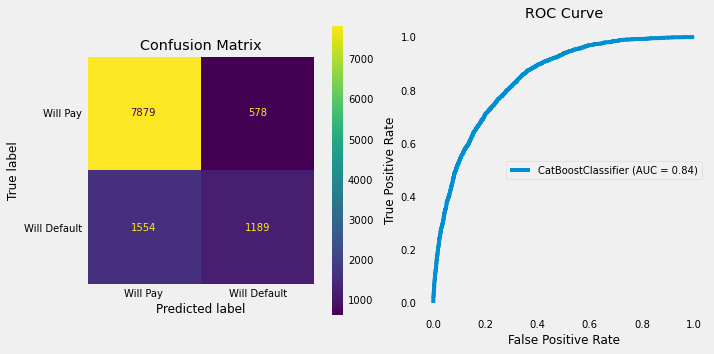

In [339]:
plot_figure(cb)

In [340]:
print(classification_report(y_test,cb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      8457
           1       0.67      0.43      0.53      2743

    accuracy                           0.81     11200
   macro avg       0.75      0.68      0.70     11200
weighted avg       0.80      0.81      0.79     11200



In [341]:
test_predictions = cb.predict_proba(test)[:, 1]
test_predictions.shape

(24000,)

In [342]:
submission = pd.DataFrame({'Applicant_ID' : test_id, 'default_status' : predictions_cb})

In [343]:
submission.to_csv('c.csv', index=False)